## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
### The camera calibration has been computed using a chessboard image and saved to the file data.p

* We first load in the camera calibration data.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle, pprint
import pickle
%matplotlib inline
#%matplotlib qt
# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
pkl_file=  open( "data.pkl", "rb" ) 
mtx = pickle.load(pkl_file)
dist = pickle.load(pkl_file)
pkl_file.close()

print(dist)



[[ -4.36704121e+00   9.95932047e+00   9.22104545e-02   4.51441551e-02
    1.01267607e+03]]


## Apply distortion correct to raw image

True

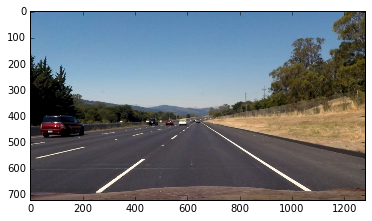

In [2]:
import matplotlib.image as mpimg
from PIL import Image
# Read in an image
img = mpimg.imread('test_images/straight_lines2.jpg',1)

undist = cv2.undistort(img, mtx, dist, None, mtx)

#plt.imshow(img)
plt.imshow(undist)
#im2 = img.convert("RGB")
savim = cv2.cvtColor(undist, cv2.COLOR_BGR2RGB)
cv2.imwrite("undist_strlin.jpg", savim)
#plt.savefig('undistort.png')

## Binary Image

Use color transforms, gradients, etc., to create a thresholded binary image.

(720, 1280)
[  0 255   0]
(720, 1280)


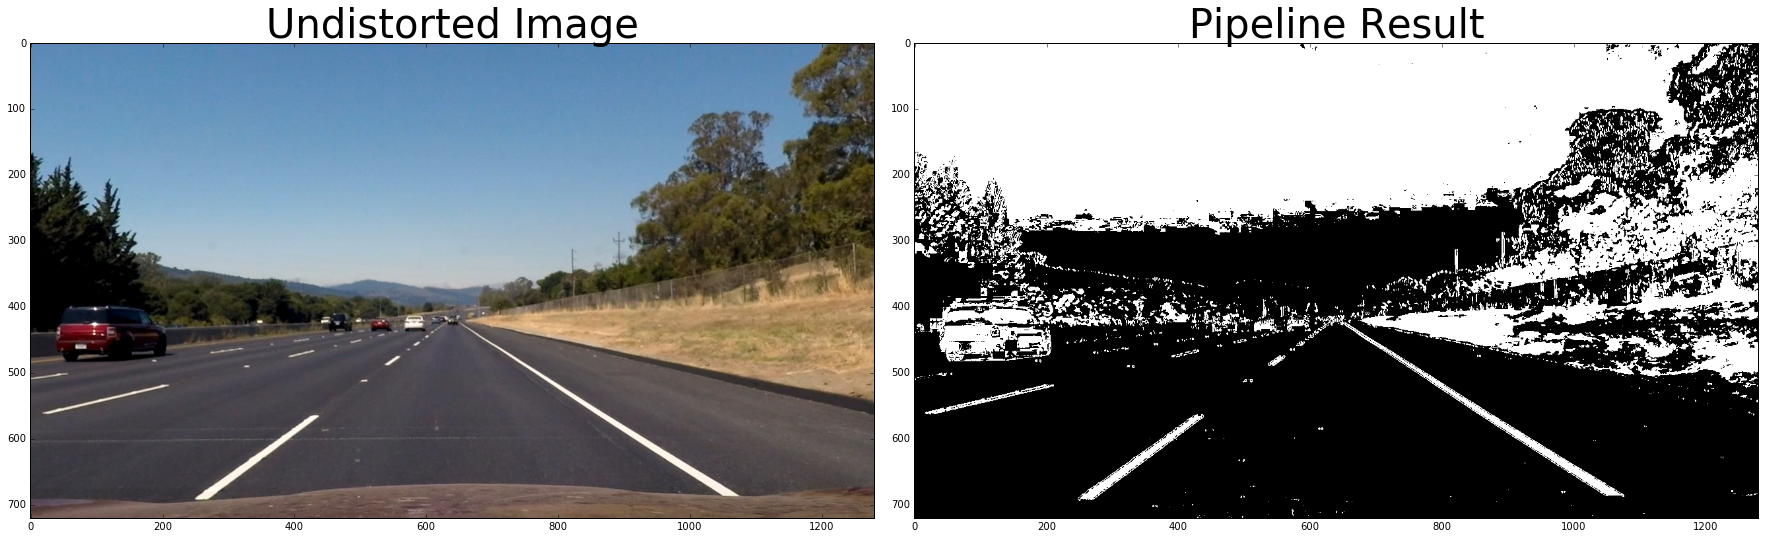

In [3]:
def pipeline(img, s_thresh=(90, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    R_Chan = img[:,:,0]
    
    print(gray.shape)
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1) ] = 1

    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.uint8(np.dstack(( sxbinary, s_binary,np.zeros_like(sxbinary))) * 255)

    return combined_binary, color_binary, sxbinary
    
thresh_bin, cb, sxbin = pipeline(undist)

fog = np.nonzero(cb)
print(cb[0][1073])


# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist)
ax1.set_title('Undistorted Image', fontsize=40)

print(thresh_bin.shape)

ax2.imshow(thresh_bin, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

cv2.imwrite("Thresh_bin_im.jpg", thresh_bin*255)
plt.savefig('Thresh_bin.png')


### Perspective

Apply a perspective transform to rectify binary image ("birds-eye view").

imgs(1280, 720)


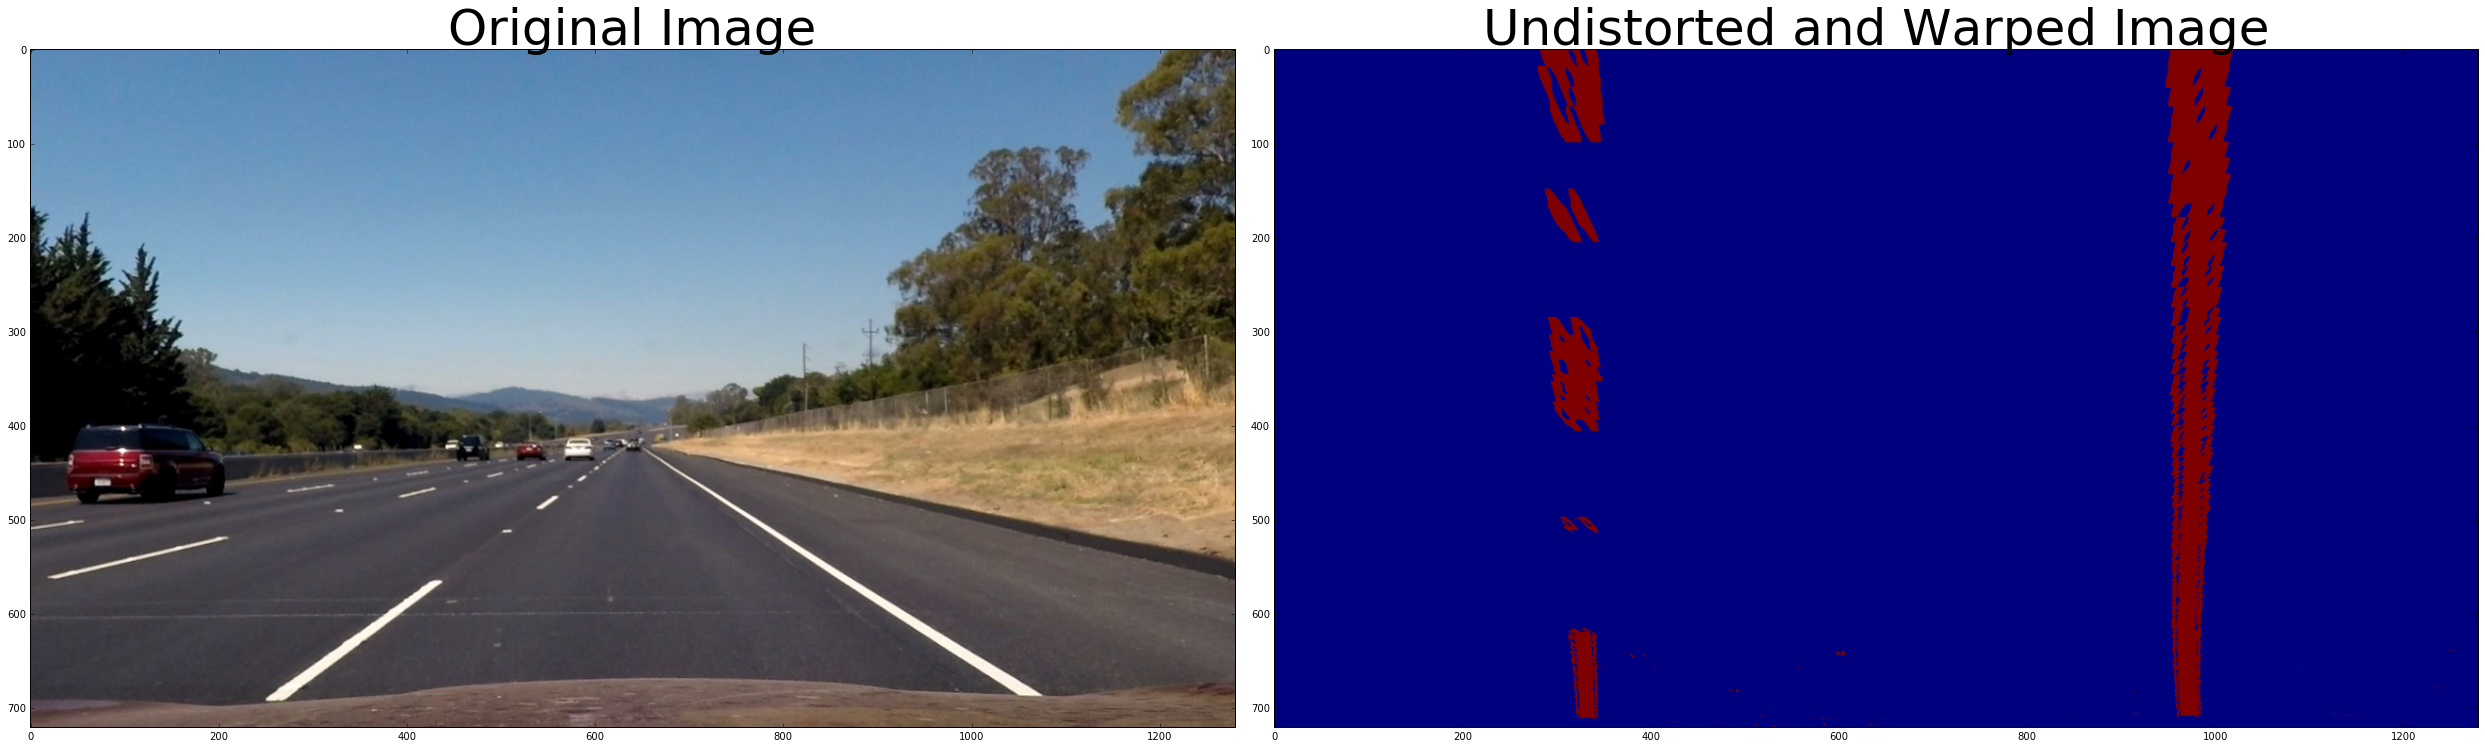

In [4]:


def scene_unwarp(img, src, dst):

    
    ret = True # may need to analyse section
    if ret == True:

        img_size = (img.shape[1], img.shape[0])
        #img_size = (794,238)
        print("imgs" +str(img_size))
        M = cv2.getPerspectiveTransform(src, dst)
        Minv = cv2.getPerspectiveTransform(dst, src)
        #Lines
        
        
        
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
        

    # Return the resulting image and matrix
    return warped, M, Minv

#src = np.float32([[722, 453], [1060, 640],[266, 640],[561,453]])

#dist = np.float32([[891, 420],[891, 640] ,[413, 640], [413,420]])

w,h = 1280,720
x,y = 0.5*w, 0.8*h
src = np.float32([[200./1280*w,720./720*h],  [453./1280*w,547./720*h],[835./1280*w,547./720*h],[1100./1280*w,720./720*h]])
dist = np.float32([[(w-x)/2.,h], [(w-x)/2.,0.82*h],  [(w+x)/2.,0.82*h],[(w+x)/2.,h]])
#print(src)

warpedout, Mo, Minv = scene_unwarp(thresh_bin, src, dist)
#undistline = cv2.line(undist,tuple(src[0]),(625,426),(255,0,0),5)
#undistline = cv2.line(undistline,tuple(src[2]),(654,425),(255,0,0),5)
#warpLine, MoLine, MinvLine = scene_unwarp(undistline, src, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(34,15))
f.tight_layout()
ax1.imshow(undist)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warpedout)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Detection
Detect lane pixels and fit to find the lane boundary.

leftx :13114
warpedout size :(720, 1280)


d:\ProgramData\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if sys.path[0] == '':


(720, 0)

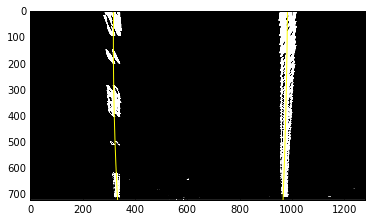

In [5]:

import numpy as np
import cv2
import matplotlib.pyplot as plt



def detectline(binary_warped):
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    print("leftx :" + str(len(leftx)))
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit,   right_fit, out_img , left_lane_inds,nonzeroy,nonzerox, right_lane_inds,leftx, rightx, lefty, righty

left_fit, right_fit, out_img, left_lane_inds,nonzeroy,nonzerox, right_lane_inds ,leftx, rightx, lefty, righty = detectline(warpedout)

print("warpedout size :" +str(warpedout.shape))

# Generate x and y values for plotting
ploty = np.linspace(0, warpedout.shape[0]-1, warpedout.shape[0] )

left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

#out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
#out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


In [6]:
print(leftx[719])

341


### Curvature

In [7]:


def r_curvature(leftx, lefty, rightx, righty, ploty):
    y_eval = np.max(ploty)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    # Example values: 632.1 m    626.2 m
    
    arrlength = 719
    
    if len(rightx) <719:
        arrlength = len(rightx)-1
        
    midpoint = (abs(640-((rightx[ arrlength]) + (leftx[arrlength]))/2))*xm_per_pix
    
    
    return left_curverad, right_curverad, midpoint

left_curverad, right_curverad, midpoint = r_curvature(leftx, lefty, rightx, righty, ploty)

print(left_curverad, 'm', right_curverad, 'm')
curvature = (left_curverad+right_curverad)/2
print("midpoint deviation " + str(midpoint)+"m")

3664.51781607 m 7892.81300183 m
midpoint deviation 0.0845714285714m


In [8]:
print(len(rightx))
print(rightx[719])
print(leftx[719])

29363
971
341


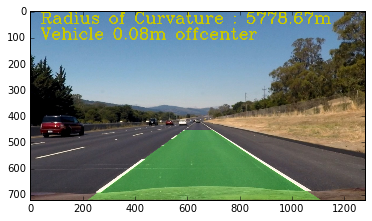

In [9]:
def laneIm(warpedout,left_fitx, ploty, right_fitx, Minv,midpoint, curvature,undistIm)  :

    ## Create an image to draw the lines on
    warp_zero = np.zeros_like(warpedout).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warpedout.shape[1], warpedout.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistIm, 1, newwarp, 0.3, 0)
    cv2.putText(result,"Radius of Curvature : " +str(round(curvature,2)) +"m", (40,50), cv2.FONT_HERSHEY_COMPLEX , 2, (200,200,0),4)
    cv2.putText(result,"Vehicle " +str(round(midpoint,2)) +"m offcenter", (40,110), cv2.FONT_HERSHEY_COMPLEX , 2, (200,200,0),4)
    return result
    
result = laneIm(warpedout,left_fitx, ploty, right_fitx, Minv,midpoint, curvature,undist)           
           
plt.imshow(result)

## Video Pipeline

Process IMage Function

In [10]:
def process_image(image):
    
    pkl_file=  open( "data.pkl", "rb" ) 
    mtx = pickle.load(pkl_file)
    dist = pickle.load(pkl_file)
    pkl_file.close()

    undist = cv2.undistort(image, mtx, dist, None, mtx)
    thresh_bin, cb, sxbin = pipeline(undist)
    w,h = 1280,720
    x,y = 0.5*w, 0.8*h
    src = np.float32([[200./1280*w,720./720*h],  [453./1280*w,547./720*h],[835./1280*w,547./720*h],[1100./1280*w,720./720*h]])
    dist = np.float32([[(w-x)/2.,h], [(w-x)/2.,0.82*h],  [(w+x)/2.,0.82*h],[(w+x)/2.,h]])
    warpedout, Mo, Minv = scene_unwarp(thresh_bin, src, dist)
    left_fit, right_fit, out_img, left_lane_inds,nonzeroy,nonzerox, right_lane_inds ,leftx, rightx, lefty, righty = detectline(warpedout)

    print("warpedout size :" +str(warpedout.shape))

    # Generate x and y values for plotting
    ploty = np.linspace(0, warpedout.shape[0]-1, warpedout.shape[0] )

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    left_curverad, right_curverad, midpoint = r_curvature(leftx, lefty, rightx, righty, ploty)
    
    curvature = (left_curverad+right_curverad)/2
    
    result = laneIm(warpedout,left_fitx, ploty, right_fitx, Minv,midpoint, curvature, undist)  
    
    return result


Run code on video

In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle, pprint
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#%matplotlib qt
# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()


vid_output = 'd_out.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(vid_output, audio=False)


(720, 1280)
imgs(1280, 720)
leftx :10341
warpedout size :(720, 1280)
[MoviePy] >>>> Building video d_out.mp4
[MoviePy] Writing video d_out.mp4


  0%|                                                                      | 0/485 [00:00<?, ?it/s]

(720, 1280)
imgs(1280, 720)
leftx :10341
warpedout size :(720, 1280)


  0%|▏                                                             | 1/485 [00:00<01:34,  5.11it/s]

(720, 1280)
imgs(1280, 720)
leftx :10181
warpedout size :(720, 1280)


  0%|▎                                                             | 2/485 [00:00<01:35,  5.06it/s]

(720, 1280)
imgs(1280, 720)
leftx :11394
warpedout size :(720, 1280)


  1%|▍                                                             | 3/485 [00:00<01:35,  5.04it/s]

(720, 1280)
imgs(1280, 720)
leftx :8835
warpedout size :(720, 1280)


  1%|▌                                                             | 4/485 [00:00<01:35,  5.01it/s]

(720, 1280)
imgs(1280, 720)
leftx :9813
warpedout size :(720, 1280)


  1%|▋                                                             | 5/485 [00:01<01:35,  5.01it/s]

(720, 1280)
imgs(1280, 720)
leftx :8589
warpedout size :(720, 1280)


  1%|▊                                                             | 6/485 [00:01<01:35,  5.01it/s]

(720, 1280)
imgs(1280, 720)
leftx :8281
warpedout size :(720, 1280)


  1%|▉                                                             | 7/485 [00:01<01:38,  4.86it/s]

(720, 1280)
imgs(1280, 720)
leftx :9944
warpedout size :(720, 1280)


  2%|█                                                             | 8/485 [00:01<01:37,  4.91it/s]

(720, 1280)
imgs(1280, 720)
leftx :9244
warpedout size :(720, 1280)


  2%|█▏                                                            | 9/485 [00:01<01:37,  4.90it/s]

(720, 1280)
imgs(1280, 720)
leftx :10408
warpedout size :(720, 1280)


  2%|█▎                                                           | 10/485 [00:02<01:36,  4.91it/s]

(720, 1280)
imgs(1280, 720)
leftx :7275
warpedout size :(720, 1280)


  2%|█▍                                                           | 11/485 [00:02<01:35,  4.94it/s]

(720, 1280)
imgs(1280, 720)
leftx :6677
warpedout size :(720, 1280)


  2%|█▌                                                           | 12/485 [00:02<01:35,  4.94it/s]

(720, 1280)
imgs(1280, 720)
leftx :8063
warpedout size :(720, 1280)


  3%|█▋                                                           | 13/485 [00:02<01:39,  4.74it/s]

(720, 1280)
imgs(1280, 720)
leftx :6747
warpedout size :(720, 1280)


  3%|█▊                                                           | 14/485 [00:02<01:37,  4.84it/s]

(720, 1280)
imgs(1280, 720)
leftx :7103
warpedout size :(720, 1280)


  3%|█▉                                                           | 15/485 [00:03<01:40,  4.68it/s]

(720, 1280)
imgs(1280, 720)
leftx :6739
warpedout size :(720, 1280)


  3%|██                                                           | 16/485 [00:03<01:48,  4.32it/s]

(720, 1280)
imgs(1280, 720)
leftx :6952
warpedout size :(720, 1280)


  4%|██▏                                                          | 17/485 [00:03<01:46,  4.39it/s]

(720, 1280)
imgs(1280, 720)
leftx :5795
warpedout size :(720, 1280)


  4%|██▎                                                          | 18/485 [00:03<01:43,  4.53it/s]

(720, 1280)
imgs(1280, 720)
leftx :5688
warpedout size :(720, 1280)


  4%|██▍                                                          | 19/485 [00:04<01:43,  4.50it/s]

(720, 1280)
imgs(1280, 720)
leftx :5059
warpedout size :(720, 1280)


  4%|██▌                                                          | 20/485 [00:04<01:41,  4.58it/s]

(720, 1280)
imgs(1280, 720)
leftx :4960
warpedout size :(720, 1280)


  4%|██▋                                                          | 21/485 [00:04<01:38,  4.71it/s]

(720, 1280)
imgs(1280, 720)
leftx :6843
warpedout size :(720, 1280)


  5%|██▊                                                          | 22/485 [00:04<01:38,  4.72it/s]

(720, 1280)
imgs(1280, 720)
leftx :6668
warpedout size :(720, 1280)


  5%|██▉                                                          | 23/485 [00:04<01:38,  4.70it/s]

(720, 1280)
imgs(1280, 720)
leftx :5795
warpedout size :(720, 1280)


  5%|███                                                          | 24/485 [00:05<01:36,  4.76it/s]

(720, 1280)
imgs(1280, 720)
leftx :6738
warpedout size :(720, 1280)


  5%|███▏                                                         | 25/485 [00:05<01:35,  4.81it/s]

(720, 1280)
imgs(1280, 720)
leftx :6102
warpedout size :(720, 1280)


  5%|███▎                                                         | 26/485 [00:05<01:35,  4.80it/s]

(720, 1280)
imgs(1280, 720)
leftx :5476
warpedout size :(720, 1280)


  6%|███▍                                                         | 27/485 [00:05<01:34,  4.83it/s]

(720, 1280)
imgs(1280, 720)
leftx :7062
warpedout size :(720, 1280)


  6%|███▌                                                         | 28/485 [00:05<01:33,  4.88it/s]

(720, 1280)
imgs(1280, 720)
leftx :6651
warpedout size :(720, 1280)


  6%|███▋                                                         | 29/485 [00:06<01:33,  4.88it/s]

(720, 1280)
imgs(1280, 720)
leftx :7325
warpedout size :(720, 1280)


  6%|███▊                                                         | 30/485 [00:06<01:32,  4.91it/s]

(720, 1280)
imgs(1280, 720)
leftx :7888
warpedout size :(720, 1280)


  6%|███▉                                                         | 31/485 [00:06<01:31,  4.94it/s]

(720, 1280)
imgs(1280, 720)
leftx :7222
warpedout size :(720, 1280)


  7%|████                                                         | 32/485 [00:06<01:30,  5.00it/s]

(720, 1280)
imgs(1280, 720)
leftx :7643
warpedout size :(720, 1280)


  7%|████▏                                                        | 33/485 [00:06<01:30,  4.99it/s]

(720, 1280)
imgs(1280, 720)
leftx :8790
warpedout size :(720, 1280)


  7%|████▎                                                        | 34/485 [00:07<01:32,  4.90it/s]

(720, 1280)
imgs(1280, 720)
leftx :7849
warpedout size :(720, 1280)


  7%|████▍                                                        | 35/485 [00:07<01:33,  4.83it/s]

(720, 1280)
imgs(1280, 720)
leftx :6915
warpedout size :(720, 1280)


  7%|████▌                                                        | 36/485 [00:07<01:32,  4.86it/s]

(720, 1280)
imgs(1280, 720)
leftx :6841
warpedout size :(720, 1280)


  8%|████▋                                                        | 37/485 [00:07<01:31,  4.92it/s]

(720, 1280)
imgs(1280, 720)
leftx :6926
warpedout size :(720, 1280)


  8%|████▊                                                        | 38/485 [00:07<01:38,  4.55it/s]

(720, 1280)
imgs(1280, 720)
leftx :6789
warpedout size :(720, 1280)


  8%|████▉                                                        | 39/485 [00:08<01:42,  4.34it/s]

(720, 1280)
imgs(1280, 720)
leftx :7821
warpedout size :(720, 1280)


  8%|█████                                                        | 40/485 [00:08<01:52,  3.95it/s]

(720, 1280)
imgs(1280, 720)
leftx :8601
warpedout size :(720, 1280)


  8%|█████▏                                                       | 41/485 [00:08<01:53,  3.90it/s]

(720, 1280)
imgs(1280, 720)
leftx :9314
warpedout size :(720, 1280)


  9%|█████▎                                                       | 42/485 [00:09<01:57,  3.76it/s]

(720, 1280)
imgs(1280, 720)
leftx :8687
warpedout size :(720, 1280)


  9%|█████▍                                                       | 43/485 [00:09<01:59,  3.70it/s]

(720, 1280)
imgs(1280, 720)
leftx :7569
warpedout size :(720, 1280)


  9%|█████▌                                                       | 44/485 [00:09<01:50,  3.99it/s]

(720, 1280)
imgs(1280, 720)
leftx :6667
warpedout size :(720, 1280)


  9%|█████▋                                                       | 45/485 [00:09<01:43,  4.23it/s]

(720, 1280)
imgs(1280, 720)
leftx :6339
warpedout size :(720, 1280)


  9%|█████▊                                                       | 46/485 [00:09<01:38,  4.46it/s]

(720, 1280)
imgs(1280, 720)
leftx :7715
warpedout size :(720, 1280)


 10%|█████▉                                                       | 47/485 [00:10<01:34,  4.62it/s]

(720, 1280)
imgs(1280, 720)
leftx :7993
warpedout size :(720, 1280)


 10%|██████                                                       | 48/485 [00:10<01:33,  4.69it/s]

(720, 1280)
imgs(1280, 720)
leftx :7544
warpedout size :(720, 1280)


 10%|██████▏                                                      | 49/485 [00:10<01:31,  4.77it/s]

(720, 1280)
imgs(1280, 720)
leftx :6912
warpedout size :(720, 1280)


 10%|██████▎                                                      | 50/485 [00:10<01:31,  4.77it/s]

(720, 1280)
imgs(1280, 720)
leftx :6771
warpedout size :(720, 1280)


 11%|██████▍                                                      | 51/485 [00:10<01:31,  4.74it/s]

(720, 1280)
imgs(1280, 720)
leftx :6668
warpedout size :(720, 1280)


 11%|██████▌                                                      | 52/485 [00:11<01:31,  4.71it/s]

(720, 1280)
imgs(1280, 720)
leftx :6179
warpedout size :(720, 1280)


 11%|██████▋                                                      | 53/485 [00:11<01:31,  4.74it/s]

(720, 1280)
imgs(1280, 720)
leftx :3036
warpedout size :(720, 1280)


 11%|██████▊                                                      | 54/485 [00:11<01:29,  4.83it/s]

(720, 1280)
imgs(1280, 720)
leftx :6790
warpedout size :(720, 1280)


 11%|██████▉                                                      | 55/485 [00:11<01:28,  4.84it/s]

(720, 1280)
imgs(1280, 720)
leftx :7123
warpedout size :(720, 1280)


 12%|███████                                                      | 56/485 [00:12<01:29,  4.79it/s]

(720, 1280)
imgs(1280, 720)
leftx :7727
warpedout size :(720, 1280)


 12%|███████▏                                                     | 57/485 [00:12<01:32,  4.62it/s]

(720, 1280)
imgs(1280, 720)
leftx :7571
warpedout size :(720, 1280)


 12%|███████▎                                                     | 58/485 [00:12<01:32,  4.61it/s]

(720, 1280)
imgs(1280, 720)
leftx :6959
warpedout size :(720, 1280)


 12%|███████▍                                                     | 59/485 [00:12<01:31,  4.66it/s]

(720, 1280)
imgs(1280, 720)
leftx :6893
warpedout size :(720, 1280)


 12%|███████▌                                                     | 60/485 [00:12<01:30,  4.72it/s]

(720, 1280)
imgs(1280, 720)
leftx :8085
warpedout size :(720, 1280)


 13%|███████▋                                                     | 61/485 [00:13<01:29,  4.76it/s]

(720, 1280)
imgs(1280, 720)
leftx :8184
warpedout size :(720, 1280)


 13%|███████▊                                                     | 62/485 [00:13<01:27,  4.83it/s]

(720, 1280)
imgs(1280, 720)
leftx :8653
warpedout size :(720, 1280)


 13%|███████▉                                                     | 63/485 [00:13<01:27,  4.82it/s]

(720, 1280)
imgs(1280, 720)
leftx :9070
warpedout size :(720, 1280)


 13%|████████                                                     | 64/485 [00:13<01:26,  4.86it/s]

(720, 1280)
imgs(1280, 720)
leftx :9057
warpedout size :(720, 1280)


 13%|████████▏                                                    | 65/485 [00:13<01:26,  4.84it/s]

(720, 1280)
imgs(1280, 720)
leftx :8715
warpedout size :(720, 1280)


 14%|████████▎                                                    | 66/485 [00:14<01:24,  4.93it/s]

(720, 1280)
imgs(1280, 720)
leftx :8621
warpedout size :(720, 1280)


 14%|████████▍                                                    | 67/485 [00:14<01:23,  4.99it/s]

(720, 1280)
imgs(1280, 720)
leftx :9220
warpedout size :(720, 1280)


 14%|████████▌                                                    | 68/485 [00:14<01:23,  5.01it/s]

(720, 1280)
imgs(1280, 720)
leftx :8884
warpedout size :(720, 1280)


 14%|████████▋                                                    | 69/485 [00:14<01:22,  5.05it/s]

(720, 1280)
imgs(1280, 720)
leftx :9622
warpedout size :(720, 1280)


 14%|████████▊                                                    | 70/485 [00:14<01:23,  5.00it/s]

(720, 1280)
imgs(1280, 720)
leftx :10175
warpedout size :(720, 1280)


 15%|████████▉                                                    | 71/485 [00:15<01:22,  5.00it/s]

(720, 1280)
imgs(1280, 720)
leftx :10413
warpedout size :(720, 1280)


 15%|█████████                                                    | 72/485 [00:15<01:22,  4.98it/s]

(720, 1280)
imgs(1280, 720)
leftx :10958
warpedout size :(720, 1280)


 15%|█████████▏                                                   | 73/485 [00:15<01:22,  5.01it/s]

(720, 1280)
imgs(1280, 720)
leftx :11516
warpedout size :(720, 1280)


 15%|█████████▎                                                   | 74/485 [00:15<01:21,  5.02it/s]

(720, 1280)
imgs(1280, 720)
leftx :11486
warpedout size :(720, 1280)


 15%|█████████▍                                                   | 75/485 [00:15<01:22,  4.99it/s]

(720, 1280)
imgs(1280, 720)
leftx :11267
warpedout size :(720, 1280)


 16%|█████████▌                                                   | 76/485 [00:16<01:21,  5.04it/s]

(720, 1280)
imgs(1280, 720)
leftx :11559
warpedout size :(720, 1280)


 16%|█████████▋                                                   | 77/485 [00:16<01:21,  5.04it/s]

(720, 1280)
imgs(1280, 720)
leftx :12448
warpedout size :(720, 1280)


 16%|█████████▊                                                   | 78/485 [00:16<01:20,  5.06it/s]

(720, 1280)
imgs(1280, 720)
leftx :11989
warpedout size :(720, 1280)


 16%|█████████▉                                                   | 79/485 [00:16<01:20,  5.05it/s]

(720, 1280)
imgs(1280, 720)
leftx :11850
warpedout size :(720, 1280)


 16%|██████████                                                   | 80/485 [00:16<01:19,  5.06it/s]

(720, 1280)
imgs(1280, 720)
leftx :11193
warpedout size :(720, 1280)


 17%|██████████▏                                                  | 81/485 [00:17<01:19,  5.08it/s]

(720, 1280)
imgs(1280, 720)
leftx :12894
warpedout size :(720, 1280)


 17%|██████████▎                                                  | 82/485 [00:17<01:20,  4.98it/s]

(720, 1280)
imgs(1280, 720)
leftx :1995
warpedout size :(720, 1280)


 17%|██████████▍                                                  | 83/485 [00:17<01:23,  4.80it/s]

(720, 1280)
imgs(1280, 720)
leftx :12436
warpedout size :(720, 1280)


 17%|██████████▌                                                  | 84/485 [00:17<01:23,  4.81it/s]

(720, 1280)
imgs(1280, 720)
leftx :2617
warpedout size :(720, 1280)


 18%|██████████▋                                                  | 85/485 [00:17<01:22,  4.85it/s]

(720, 1280)
imgs(1280, 720)
leftx :2388
warpedout size :(720, 1280)


 18%|██████████▊                                                  | 86/485 [00:18<01:22,  4.84it/s]

(720, 1280)
imgs(1280, 720)
leftx :10875
warpedout size :(720, 1280)


 18%|██████████▉                                                  | 87/485 [00:18<01:22,  4.85it/s]

(720, 1280)
imgs(1280, 720)
leftx :10603
warpedout size :(720, 1280)


 18%|███████████                                                  | 88/485 [00:18<01:21,  4.88it/s]

(720, 1280)
imgs(1280, 720)
leftx :10245
warpedout size :(720, 1280)


 18%|███████████▏                                                 | 89/485 [00:18<01:20,  4.91it/s]

(720, 1280)
imgs(1280, 720)
leftx :11306
warpedout size :(720, 1280)


 19%|███████████▎                                                 | 90/485 [00:18<01:19,  4.96it/s]

(720, 1280)
imgs(1280, 720)
leftx :10564
warpedout size :(720, 1280)


 19%|███████████▍                                                 | 91/485 [00:19<01:19,  4.93it/s]

(720, 1280)
imgs(1280, 720)
leftx :10402
warpedout size :(720, 1280)


 19%|███████████▌                                                 | 92/485 [00:19<01:20,  4.90it/s]

(720, 1280)
imgs(1280, 720)
leftx :11334
warpedout size :(720, 1280)


 19%|███████████▋                                                 | 93/485 [00:19<01:19,  4.92it/s]

(720, 1280)
imgs(1280, 720)
leftx :11533
warpedout size :(720, 1280)


 19%|███████████▊                                                 | 94/485 [00:19<01:18,  4.95it/s]

(720, 1280)
imgs(1280, 720)
leftx :10275
warpedout size :(720, 1280)


 20%|███████████▉                                                 | 95/485 [00:19<01:18,  4.99it/s]

(720, 1280)
imgs(1280, 720)
leftx :9966
warpedout size :(720, 1280)


 20%|████████████                                                 | 96/485 [00:20<01:17,  5.02it/s]

(720, 1280)
imgs(1280, 720)
leftx :8364
warpedout size :(720, 1280)


 20%|████████████▏                                                | 97/485 [00:20<01:17,  4.99it/s]

(720, 1280)
imgs(1280, 720)
leftx :7818
warpedout size :(720, 1280)


 20%|████████████▎                                                | 98/485 [00:20<01:16,  5.06it/s]

(720, 1280)
imgs(1280, 720)
leftx :7195
warpedout size :(720, 1280)


 20%|████████████▍                                                | 99/485 [00:20<01:16,  5.03it/s]

(720, 1280)
imgs(1280, 720)
leftx :7023
warpedout size :(720, 1280)


 21%|████████████▎                                               | 100/485 [00:20<01:16,  5.02it/s]

(720, 1280)
imgs(1280, 720)
leftx :7470
warpedout size :(720, 1280)


 21%|████████████▍                                               | 101/485 [00:21<01:16,  5.03it/s]

(720, 1280)
imgs(1280, 720)
leftx :8203
warpedout size :(720, 1280)


 21%|████████████▌                                               | 102/485 [00:21<01:16,  4.99it/s]

(720, 1280)
imgs(1280, 720)
leftx :7856
warpedout size :(720, 1280)


 21%|████████████▋                                               | 103/485 [00:21<01:15,  5.05it/s]

(720, 1280)
imgs(1280, 720)
leftx :8337
warpedout size :(720, 1280)


 21%|████████████▊                                               | 104/485 [00:21<01:14,  5.08it/s]

(720, 1280)
imgs(1280, 720)
leftx :8768
warpedout size :(720, 1280)


 22%|████████████▉                                               | 105/485 [00:21<01:14,  5.08it/s]

(720, 1280)
imgs(1280, 720)
leftx :8256
warpedout size :(720, 1280)


 22%|█████████████                                               | 106/485 [00:22<01:14,  5.07it/s]

(720, 1280)
imgs(1280, 720)
leftx :7174
warpedout size :(720, 1280)


 22%|█████████████▏                                              | 107/485 [00:22<01:14,  5.05it/s]

(720, 1280)
imgs(1280, 720)
leftx :6372
warpedout size :(720, 1280)


 22%|█████████████▎                                              | 108/485 [00:22<01:14,  5.07it/s]

(720, 1280)
imgs(1280, 720)
leftx :6391
warpedout size :(720, 1280)


 22%|█████████████▍                                              | 109/485 [00:22<01:14,  5.06it/s]

(720, 1280)
imgs(1280, 720)
leftx :6542
warpedout size :(720, 1280)


 23%|█████████████▌                                              | 110/485 [00:22<01:14,  5.06it/s]

(720, 1280)
imgs(1280, 720)
leftx :6404
warpedout size :(720, 1280)


 23%|█████████████▋                                              | 111/485 [00:23<01:16,  4.89it/s]

(720, 1280)
imgs(1280, 720)
leftx :6176
warpedout size :(720, 1280)


 23%|█████████████▊                                              | 112/485 [00:23<01:18,  4.75it/s]

(720, 1280)
imgs(1280, 720)
leftx :5604
warpedout size :(720, 1280)


 23%|█████████████▉                                              | 113/485 [00:23<01:17,  4.77it/s]

(720, 1280)
imgs(1280, 720)
leftx :6288
warpedout size :(720, 1280)


 24%|██████████████                                              | 114/485 [00:23<01:18,  4.70it/s]

(720, 1280)
imgs(1280, 720)
leftx :5910
warpedout size :(720, 1280)


 24%|██████████████▏                                             | 115/485 [00:23<01:17,  4.80it/s]

(720, 1280)
imgs(1280, 720)
leftx :5545
warpedout size :(720, 1280)


 24%|██████████████▎                                             | 116/485 [00:24<01:16,  4.80it/s]

(720, 1280)
imgs(1280, 720)
leftx :5657
warpedout size :(720, 1280)


 24%|██████████████▍                                             | 117/485 [00:24<01:16,  4.79it/s]

(720, 1280)
imgs(1280, 720)
leftx :6285
warpedout size :(720, 1280)


 24%|██████████████▌                                             | 118/485 [00:24<01:15,  4.87it/s]

(720, 1280)
imgs(1280, 720)
leftx :5338
warpedout size :(720, 1280)


 25%|██████████████▋                                             | 119/485 [00:24<01:17,  4.75it/s]

(720, 1280)
imgs(1280, 720)
leftx :4968
warpedout size :(720, 1280)


 25%|██████████████▊                                             | 120/485 [00:25<01:16,  4.78it/s]

(720, 1280)
imgs(1280, 720)
leftx :4683
warpedout size :(720, 1280)


 25%|██████████████▉                                             | 121/485 [00:25<01:14,  4.88it/s]

(720, 1280)
imgs(1280, 720)
leftx :4244
warpedout size :(720, 1280)


 25%|███████████████                                             | 122/485 [00:25<01:14,  4.84it/s]

(720, 1280)
imgs(1280, 720)
leftx :3839
warpedout size :(720, 1280)


 25%|███████████████▏                                            | 123/485 [00:25<01:13,  4.92it/s]

(720, 1280)
imgs(1280, 720)
leftx :3566
warpedout size :(720, 1280)


 26%|███████████████▎                                            | 124/485 [00:25<01:14,  4.87it/s]

(720, 1280)
imgs(1280, 720)
leftx :3087
warpedout size :(720, 1280)


 26%|███████████████▍                                            | 125/485 [00:26<01:14,  4.84it/s]

(720, 1280)
imgs(1280, 720)
leftx :2810
warpedout size :(720, 1280)


 26%|███████████████▌                                            | 126/485 [00:26<01:13,  4.88it/s]

(720, 1280)
imgs(1280, 720)
leftx :8287
warpedout size :(720, 1280)


 26%|███████████████▋                                            | 127/485 [00:26<01:12,  4.94it/s]

(720, 1280)
imgs(1280, 720)
leftx :2334
warpedout size :(720, 1280)


 26%|███████████████▊                                            | 128/485 [00:26<01:14,  4.77it/s]

(720, 1280)
imgs(1280, 720)
leftx :2077
warpedout size :(720, 1280)


 27%|███████████████▉                                            | 129/485 [00:26<01:22,  4.30it/s]

(720, 1280)
imgs(1280, 720)
leftx :1559
warpedout size :(720, 1280)


 27%|████████████████                                            | 130/485 [00:27<01:26,  4.11it/s]

(720, 1280)
imgs(1280, 720)
leftx :5585
warpedout size :(720, 1280)


 27%|████████████████▏                                           | 131/485 [00:27<01:28,  4.01it/s]

(720, 1280)
imgs(1280, 720)
leftx :14140
warpedout size :(720, 1280)


 27%|████████████████▎                                           | 132/485 [00:27<01:28,  4.01it/s]

(720, 1280)
imgs(1280, 720)
leftx :15260
warpedout size :(720, 1280)


 27%|████████████████▍                                           | 133/485 [00:27<01:26,  4.08it/s]

(720, 1280)
imgs(1280, 720)
leftx :14702
warpedout size :(720, 1280)


 28%|████████████████▌                                           | 134/485 [00:28<01:24,  4.16it/s]

(720, 1280)
imgs(1280, 720)
leftx :13539
warpedout size :(720, 1280)


 28%|████████████████▋                                           | 135/485 [00:28<01:20,  4.32it/s]

(720, 1280)
imgs(1280, 720)
leftx :9644
warpedout size :(720, 1280)


 28%|████████████████▊                                           | 136/485 [00:28<01:18,  4.44it/s]

(720, 1280)
imgs(1280, 720)
leftx :12480
warpedout size :(720, 1280)


 28%|████████████████▉                                           | 137/485 [00:28<01:16,  4.57it/s]

(720, 1280)
imgs(1280, 720)
leftx :13574
warpedout size :(720, 1280)


 28%|█████████████████                                           | 138/485 [00:29<01:15,  4.60it/s]

(720, 1280)
imgs(1280, 720)
leftx :10628
warpedout size :(720, 1280)


 29%|█████████████████▏                                          | 139/485 [00:29<01:14,  4.68it/s]

(720, 1280)
imgs(1280, 720)
leftx :7769
warpedout size :(720, 1280)


 29%|█████████████████▎                                          | 140/485 [00:29<01:12,  4.75it/s]

(720, 1280)
imgs(1280, 720)
leftx :5932
warpedout size :(720, 1280)


 29%|█████████████████▍                                          | 141/485 [00:29<01:11,  4.81it/s]

(720, 1280)
imgs(1280, 720)
leftx :3787
warpedout size :(720, 1280)


 29%|█████████████████▌                                          | 142/485 [00:29<01:11,  4.80it/s]

(720, 1280)
imgs(1280, 720)
leftx :15644
warpedout size :(720, 1280)


 29%|█████████████████▋                                          | 143/485 [00:30<01:10,  4.84it/s]

(720, 1280)
imgs(1280, 720)
leftx :16017
warpedout size :(720, 1280)


 30%|█████████████████▊                                          | 144/485 [00:30<01:10,  4.83it/s]

(720, 1280)
imgs(1280, 720)
leftx :16790
warpedout size :(720, 1280)


 30%|█████████████████▉                                          | 145/485 [00:30<01:10,  4.83it/s]

(720, 1280)
imgs(1280, 720)
leftx :17173
warpedout size :(720, 1280)


 30%|██████████████████                                          | 146/485 [00:30<01:10,  4.81it/s]

(720, 1280)
imgs(1280, 720)
leftx :16858
warpedout size :(720, 1280)


 30%|██████████████████▏                                         | 147/485 [00:30<01:09,  4.85it/s]

(720, 1280)
imgs(1280, 720)
leftx :17849
warpedout size :(720, 1280)


 31%|██████████████████▎                                         | 148/485 [00:31<01:10,  4.77it/s]

(720, 1280)
imgs(1280, 720)
leftx :17886
warpedout size :(720, 1280)


 31%|██████████████████▍                                         | 149/485 [00:31<01:10,  4.79it/s]

(720, 1280)
imgs(1280, 720)
leftx :17652
warpedout size :(720, 1280)


 31%|██████████████████▌                                         | 150/485 [00:31<01:08,  4.87it/s]

(720, 1280)
imgs(1280, 720)
leftx :19169
warpedout size :(720, 1280)


 31%|██████████████████▋                                         | 151/485 [00:31<01:08,  4.87it/s]

(720, 1280)
imgs(1280, 720)
leftx :21696
warpedout size :(720, 1280)


 31%|██████████████████▊                                         | 152/485 [00:31<01:09,  4.81it/s]

(720, 1280)
imgs(1280, 720)
leftx :21796
warpedout size :(720, 1280)


 32%|██████████████████▉                                         | 153/485 [00:32<01:08,  4.82it/s]

(720, 1280)
imgs(1280, 720)
leftx :22702
warpedout size :(720, 1280)


 32%|███████████████████                                         | 154/485 [00:32<01:08,  4.81it/s]

(720, 1280)
imgs(1280, 720)
leftx :22309
warpedout size :(720, 1280)


 32%|███████████████████▏                                        | 155/485 [00:32<01:09,  4.77it/s]

(720, 1280)
imgs(1280, 720)
leftx :22418
warpedout size :(720, 1280)


 32%|███████████████████▎                                        | 156/485 [00:32<01:12,  4.52it/s]

(720, 1280)
imgs(1280, 720)
leftx :23133
warpedout size :(720, 1280)


 32%|███████████████████▍                                        | 157/485 [00:33<01:12,  4.54it/s]

(720, 1280)
imgs(1280, 720)
leftx :21828
warpedout size :(720, 1280)


 33%|███████████████████▌                                        | 158/485 [00:33<01:10,  4.61it/s]

(720, 1280)
imgs(1280, 720)
leftx :21949
warpedout size :(720, 1280)


 33%|███████████████████▋                                        | 159/485 [00:33<01:09,  4.66it/s]

(720, 1280)
imgs(1280, 720)
leftx :21267
warpedout size :(720, 1280)


 33%|███████████████████▊                                        | 160/485 [00:33<01:09,  4.71it/s]

(720, 1280)
imgs(1280, 720)
leftx :21961
warpedout size :(720, 1280)


 33%|███████████████████▉                                        | 161/485 [00:33<01:08,  4.73it/s]

(720, 1280)
imgs(1280, 720)
leftx :21512
warpedout size :(720, 1280)


 33%|████████████████████                                        | 162/485 [00:34<01:07,  4.77it/s]

(720, 1280)
imgs(1280, 720)
leftx :20221
warpedout size :(720, 1280)


 34%|████████████████████▏                                       | 163/485 [00:34<01:07,  4.79it/s]

(720, 1280)
imgs(1280, 720)
leftx :20678
warpedout size :(720, 1280)


 34%|████████████████████▎                                       | 164/485 [00:34<01:07,  4.78it/s]

(720, 1280)
imgs(1280, 720)
leftx :20217
warpedout size :(720, 1280)


 34%|████████████████████▍                                       | 165/485 [00:34<01:06,  4.80it/s]

(720, 1280)
imgs(1280, 720)
leftx :20421
warpedout size :(720, 1280)


 34%|████████████████████▌                                       | 166/485 [00:34<01:06,  4.77it/s]

(720, 1280)
imgs(1280, 720)
leftx :20404
warpedout size :(720, 1280)


 34%|████████████████████▋                                       | 167/485 [00:35<01:06,  4.78it/s]

(720, 1280)
imgs(1280, 720)
leftx :19921
warpedout size :(720, 1280)


 35%|████████████████████▊                                       | 168/485 [00:35<01:05,  4.83it/s]

(720, 1280)
imgs(1280, 720)
leftx :21023
warpedout size :(720, 1280)


 35%|████████████████████▉                                       | 169/485 [00:35<01:05,  4.80it/s]

(720, 1280)
imgs(1280, 720)
leftx :19898
warpedout size :(720, 1280)


 35%|█████████████████████                                       | 170/485 [00:35<01:06,  4.75it/s]

(720, 1280)
imgs(1280, 720)
leftx :20779
warpedout size :(720, 1280)


 35%|█████████████████████▏                                      | 171/485 [00:35<01:07,  4.64it/s]

(720, 1280)
imgs(1280, 720)
leftx :21306
warpedout size :(720, 1280)


 35%|█████████████████████▎                                      | 172/485 [00:36<01:18,  4.01it/s]

(720, 1280)
imgs(1280, 720)
leftx :20234
warpedout size :(720, 1280)


 36%|█████████████████████▍                                      | 173/485 [00:36<01:23,  3.76it/s]

(720, 1280)
imgs(1280, 720)
leftx :20892
warpedout size :(720, 1280)


 36%|█████████████████████▌                                      | 174/485 [00:36<01:17,  4.02it/s]

(720, 1280)
imgs(1280, 720)
leftx :21307
warpedout size :(720, 1280)


 36%|█████████████████████▋                                      | 175/485 [00:37<01:15,  4.10it/s]

(720, 1280)
imgs(1280, 720)
leftx :20494
warpedout size :(720, 1280)


 36%|█████████████████████▊                                      | 176/485 [00:37<01:23,  3.68it/s]

(720, 1280)
imgs(1280, 720)
leftx :19995
warpedout size :(720, 1280)


 36%|█████████████████████▉                                      | 177/485 [00:37<01:27,  3.53it/s]

(720, 1280)
imgs(1280, 720)
leftx :19698
warpedout size :(720, 1280)


 37%|██████████████████████                                      | 178/485 [00:37<01:22,  3.72it/s]

(720, 1280)
imgs(1280, 720)
leftx :19730
warpedout size :(720, 1280)


 37%|██████████████████████▏                                     | 179/485 [00:38<01:16,  4.01it/s]

(720, 1280)
imgs(1280, 720)
leftx :20100
warpedout size :(720, 1280)


 37%|██████████████████████▎                                     | 180/485 [00:38<01:12,  4.21it/s]

(720, 1280)
imgs(1280, 720)
leftx :21511
warpedout size :(720, 1280)


 37%|██████████████████████▍                                     | 181/485 [00:38<01:09,  4.40it/s]

(720, 1280)
imgs(1280, 720)
leftx :19810
warpedout size :(720, 1280)


 38%|██████████████████████▌                                     | 182/485 [00:38<01:06,  4.54it/s]

(720, 1280)
imgs(1280, 720)
leftx :19739
warpedout size :(720, 1280)


 38%|██████████████████████▋                                     | 183/485 [00:38<01:04,  4.68it/s]

(720, 1280)
imgs(1280, 720)
leftx :20320
warpedout size :(720, 1280)


 38%|██████████████████████▊                                     | 184/485 [00:39<01:03,  4.75it/s]

(720, 1280)
imgs(1280, 720)
leftx :20235
warpedout size :(720, 1280)


 38%|██████████████████████▉                                     | 185/485 [00:39<01:02,  4.81it/s]

(720, 1280)
imgs(1280, 720)
leftx :20086
warpedout size :(720, 1280)


 38%|███████████████████████                                     | 186/485 [00:39<01:01,  4.87it/s]

(720, 1280)
imgs(1280, 720)
leftx :18690
warpedout size :(720, 1280)


 39%|███████████████████████▏                                    | 187/485 [00:39<01:00,  4.91it/s]

(720, 1280)
imgs(1280, 720)
leftx :18420
warpedout size :(720, 1280)


 39%|███████████████████████▎                                    | 188/485 [00:39<01:00,  4.93it/s]

(720, 1280)
imgs(1280, 720)
leftx :17715
warpedout size :(720, 1280)


 39%|███████████████████████▍                                    | 189/485 [00:40<01:00,  4.93it/s]

(720, 1280)
imgs(1280, 720)
leftx :18312
warpedout size :(720, 1280)


 39%|███████████████████████▌                                    | 190/485 [00:40<01:01,  4.78it/s]

(720, 1280)
imgs(1280, 720)
leftx :17291
warpedout size :(720, 1280)


 39%|███████████████████████▋                                    | 191/485 [00:40<01:10,  4.15it/s]

(720, 1280)
imgs(1280, 720)
leftx :17934
warpedout size :(720, 1280)


 40%|███████████████████████▊                                    | 192/485 [00:40<01:09,  4.22it/s]

(720, 1280)
imgs(1280, 720)
leftx :16796
warpedout size :(720, 1280)


 40%|███████████████████████▉                                    | 193/485 [00:41<01:06,  4.40it/s]

(720, 1280)
imgs(1280, 720)
leftx :15282
warpedout size :(720, 1280)


 40%|████████████████████████                                    | 194/485 [00:41<01:08,  4.27it/s]

(720, 1280)
imgs(1280, 720)
leftx :15379
warpedout size :(720, 1280)


 40%|████████████████████████                                    | 195/485 [00:41<01:09,  4.16it/s]

(720, 1280)
imgs(1280, 720)
leftx :14919
warpedout size :(720, 1280)


 40%|████████████████████████▏                                   | 196/485 [00:41<01:11,  4.03it/s]

(720, 1280)
imgs(1280, 720)
leftx :14674
warpedout size :(720, 1280)


 41%|████████████████████████▎                                   | 197/485 [00:42<01:08,  4.20it/s]

(720, 1280)
imgs(1280, 720)
leftx :15850
warpedout size :(720, 1280)


 41%|████████████████████████▍                                   | 198/485 [00:42<01:06,  4.31it/s]

(720, 1280)
imgs(1280, 720)
leftx :15225
warpedout size :(720, 1280)


 41%|████████████████████████▌                                   | 199/485 [00:42<01:03,  4.47it/s]

(720, 1280)
imgs(1280, 720)
leftx :14826
warpedout size :(720, 1280)


 41%|████████████████████████▋                                   | 200/485 [00:42<01:01,  4.61it/s]

(720, 1280)
imgs(1280, 720)
leftx :14921
warpedout size :(720, 1280)


 41%|████████████████████████▊                                   | 201/485 [00:42<01:00,  4.70it/s]

(720, 1280)
imgs(1280, 720)
leftx :14680
warpedout size :(720, 1280)


 42%|████████████████████████▉                                   | 202/485 [00:43<01:00,  4.66it/s]

(720, 1280)
imgs(1280, 720)
leftx :13458
warpedout size :(720, 1280)


 42%|█████████████████████████                                   | 203/485 [00:43<01:00,  4.63it/s]

(720, 1280)
imgs(1280, 720)
leftx :12937
warpedout size :(720, 1280)


 42%|█████████████████████████▏                                  | 204/485 [00:43<01:00,  4.66it/s]

(720, 1280)
imgs(1280, 720)
leftx :12699
warpedout size :(720, 1280)


 42%|█████████████████████████▎                                  | 205/485 [00:43<01:00,  4.63it/s]

(720, 1280)
imgs(1280, 720)
leftx :13108
warpedout size :(720, 1280)


 42%|█████████████████████████▍                                  | 206/485 [00:44<01:01,  4.56it/s]

(720, 1280)
imgs(1280, 720)
leftx :13755
warpedout size :(720, 1280)


 43%|█████████████████████████▌                                  | 207/485 [00:44<01:04,  4.33it/s]

(720, 1280)
imgs(1280, 720)
leftx :13533
warpedout size :(720, 1280)


 43%|█████████████████████████▋                                  | 208/485 [00:44<01:05,  4.20it/s]

(720, 1280)
imgs(1280, 720)
leftx :13979
warpedout size :(720, 1280)


 43%|█████████████████████████▊                                  | 209/485 [00:44<01:12,  3.82it/s]

(720, 1280)
imgs(1280, 720)
leftx :15012
warpedout size :(720, 1280)


 43%|█████████████████████████▉                                  | 210/485 [00:45<01:10,  3.92it/s]

(720, 1280)
imgs(1280, 720)
leftx :14658
warpedout size :(720, 1280)


 44%|██████████████████████████                                  | 211/485 [00:45<01:10,  3.88it/s]

(720, 1280)
imgs(1280, 720)
leftx :12376
warpedout size :(720, 1280)


 44%|██████████████████████████▏                                 | 212/485 [00:45<01:06,  4.13it/s]

(720, 1280)
imgs(1280, 720)
leftx :13578
warpedout size :(720, 1280)


 44%|██████████████████████████▎                                 | 213/485 [00:45<01:02,  4.33it/s]

(720, 1280)
imgs(1280, 720)
leftx :13643
warpedout size :(720, 1280)


 44%|██████████████████████████▍                                 | 214/485 [00:45<01:00,  4.45it/s]

(720, 1280)
imgs(1280, 720)
leftx :14078
warpedout size :(720, 1280)


 44%|██████████████████████████▌                                 | 215/485 [00:46<00:58,  4.58it/s]

(720, 1280)
imgs(1280, 720)
leftx :14845
warpedout size :(720, 1280)


 45%|██████████████████████████▋                                 | 216/485 [00:46<00:57,  4.68it/s]

(720, 1280)
imgs(1280, 720)
leftx :15339
warpedout size :(720, 1280)


 45%|██████████████████████████▊                                 | 217/485 [00:46<00:56,  4.78it/s]

(720, 1280)
imgs(1280, 720)
leftx :13924
warpedout size :(720, 1280)


 45%|██████████████████████████▉                                 | 218/485 [00:46<00:55,  4.80it/s]

(720, 1280)
imgs(1280, 720)
leftx :13680
warpedout size :(720, 1280)


 45%|███████████████████████████                                 | 219/485 [00:46<00:54,  4.87it/s]

(720, 1280)
imgs(1280, 720)
leftx :12489
warpedout size :(720, 1280)


 45%|███████████████████████████▏                                | 220/485 [00:47<00:54,  4.88it/s]

(720, 1280)
imgs(1280, 720)
leftx :13228
warpedout size :(720, 1280)


 46%|███████████████████████████▎                                | 221/485 [00:47<00:53,  4.93it/s]

(720, 1280)
imgs(1280, 720)
leftx :13572
warpedout size :(720, 1280)


 46%|███████████████████████████▍                                | 222/485 [00:47<00:53,  4.92it/s]

(720, 1280)
imgs(1280, 720)
leftx :14799
warpedout size :(720, 1280)


 46%|███████████████████████████▌                                | 223/485 [00:47<00:52,  4.96it/s]

(720, 1280)
imgs(1280, 720)
leftx :14533
warpedout size :(720, 1280)


 46%|███████████████████████████▋                                | 224/485 [00:48<00:53,  4.92it/s]

(720, 1280)
imgs(1280, 720)
leftx :13518
warpedout size :(720, 1280)


 46%|███████████████████████████▊                                | 225/485 [00:48<00:52,  4.92it/s]

(720, 1280)
imgs(1280, 720)
leftx :12513
warpedout size :(720, 1280)


 47%|███████████████████████████▉                                | 226/485 [00:48<00:52,  4.90it/s]

(720, 1280)
imgs(1280, 720)
leftx :12711
warpedout size :(720, 1280)


 47%|████████████████████████████                                | 227/485 [00:48<00:52,  4.94it/s]

(720, 1280)
imgs(1280, 720)
leftx :12158
warpedout size :(720, 1280)


 47%|████████████████████████████▏                               | 228/485 [00:48<00:51,  4.96it/s]

(720, 1280)
imgs(1280, 720)
leftx :11827
warpedout size :(720, 1280)


 47%|████████████████████████████▎                               | 229/485 [00:49<00:51,  4.99it/s]

(720, 1280)
imgs(1280, 720)
leftx :13006
warpedout size :(720, 1280)


 47%|████████████████████████████▍                               | 230/485 [00:49<00:51,  4.99it/s]

(720, 1280)
imgs(1280, 720)
leftx :11650
warpedout size :(720, 1280)


 48%|████████████████████████████▌                               | 231/485 [00:49<00:51,  4.95it/s]

(720, 1280)
imgs(1280, 720)
leftx :14103
warpedout size :(720, 1280)


 48%|████████████████████████████▋                               | 232/485 [00:49<00:51,  4.93it/s]

(720, 1280)
imgs(1280, 720)
leftx :11003
warpedout size :(720, 1280)


 48%|████████████████████████████▊                               | 233/485 [00:49<00:50,  4.96it/s]

(720, 1280)
imgs(1280, 720)
leftx :13944
warpedout size :(720, 1280)


 48%|████████████████████████████▉                               | 234/485 [00:50<00:51,  4.87it/s]

(720, 1280)
imgs(1280, 720)
leftx :13347
warpedout size :(720, 1280)


 48%|█████████████████████████████                               | 235/485 [00:50<00:54,  4.59it/s]

(720, 1280)
imgs(1280, 720)
leftx :12649
warpedout size :(720, 1280)


 49%|█████████████████████████████▏                              | 236/485 [00:50<00:53,  4.69it/s]

(720, 1280)
imgs(1280, 720)
leftx :11887
warpedout size :(720, 1280)


 49%|█████████████████████████████▎                              | 237/485 [00:50<00:51,  4.81it/s]

(720, 1280)
imgs(1280, 720)
leftx :11124
warpedout size :(720, 1280)


 49%|█████████████████████████████▍                              | 238/485 [00:50<00:50,  4.88it/s]

(720, 1280)
imgs(1280, 720)
leftx :10629
warpedout size :(720, 1280)


 49%|█████████████████████████████▌                              | 239/485 [00:51<00:50,  4.90it/s]

(720, 1280)
imgs(1280, 720)
leftx :9898
warpedout size :(720, 1280)


 49%|█████████████████████████████▋                              | 240/485 [00:51<00:50,  4.89it/s]

(720, 1280)
imgs(1280, 720)
leftx :11718
warpedout size :(720, 1280)


 50%|█████████████████████████████▊                              | 241/485 [00:51<00:49,  4.94it/s]

(720, 1280)
imgs(1280, 720)
leftx :13473
warpedout size :(720, 1280)


 50%|█████████████████████████████▉                              | 242/485 [00:51<00:49,  4.92it/s]

(720, 1280)
imgs(1280, 720)
leftx :12248
warpedout size :(720, 1280)


 50%|██████████████████████████████                              | 243/485 [00:51<00:48,  4.97it/s]

(720, 1280)
imgs(1280, 720)
leftx :12302
warpedout size :(720, 1280)


 50%|██████████████████████████████▏                             | 244/485 [00:52<00:48,  5.02it/s]

(720, 1280)
imgs(1280, 720)
leftx :12082
warpedout size :(720, 1280)


 51%|██████████████████████████████▎                             | 245/485 [00:52<00:48,  4.97it/s]

(720, 1280)
imgs(1280, 720)
leftx :13946
warpedout size :(720, 1280)


 51%|██████████████████████████████▍                             | 246/485 [00:52<00:48,  4.98it/s]

(720, 1280)
imgs(1280, 720)
leftx :13144
warpedout size :(720, 1280)


 51%|██████████████████████████████▌                             | 247/485 [00:52<00:47,  4.98it/s]

(720, 1280)
imgs(1280, 720)
leftx :12258
warpedout size :(720, 1280)


 51%|██████████████████████████████▋                             | 248/485 [00:52<00:47,  4.95it/s]

(720, 1280)
imgs(1280, 720)
leftx :12972
warpedout size :(720, 1280)


 51%|██████████████████████████████▊                             | 249/485 [00:53<00:47,  4.97it/s]

(720, 1280)
imgs(1280, 720)
leftx :11189
warpedout size :(720, 1280)


 52%|██████████████████████████████▉                             | 250/485 [00:53<00:47,  4.96it/s]

(720, 1280)
imgs(1280, 720)
leftx :11420
warpedout size :(720, 1280)


 52%|███████████████████████████████                             | 251/485 [00:53<00:46,  4.98it/s]

(720, 1280)
imgs(1280, 720)
leftx :10440
warpedout size :(720, 1280)


 52%|███████████████████████████████▏                            | 252/485 [00:53<00:46,  4.99it/s]

(720, 1280)
imgs(1280, 720)
leftx :10374
warpedout size :(720, 1280)


 52%|███████████████████████████████▎                            | 253/485 [00:53<00:46,  5.02it/s]

(720, 1280)
imgs(1280, 720)
leftx :12768
warpedout size :(720, 1280)


 52%|███████████████████████████████▍                            | 254/485 [00:54<00:45,  5.03it/s]

(720, 1280)
imgs(1280, 720)
leftx :11842
warpedout size :(720, 1280)


 53%|███████████████████████████████▌                            | 255/485 [00:54<00:45,  5.01it/s]

(720, 1280)
imgs(1280, 720)
leftx :13153
warpedout size :(720, 1280)


 53%|███████████████████████████████▋                            | 256/485 [00:54<00:45,  4.99it/s]

(720, 1280)
imgs(1280, 720)
leftx :14108
warpedout size :(720, 1280)


 53%|███████████████████████████████▊                            | 257/485 [00:54<00:47,  4.84it/s]

(720, 1280)
imgs(1280, 720)
leftx :12521
warpedout size :(720, 1280)


 53%|███████████████████████████████▉                            | 258/485 [00:54<00:46,  4.87it/s]

(720, 1280)
imgs(1280, 720)
leftx :14140
warpedout size :(720, 1280)


 53%|████████████████████████████████                            | 259/485 [00:55<00:46,  4.87it/s]

(720, 1280)
imgs(1280, 720)
leftx :12293
warpedout size :(720, 1280)


 54%|████████████████████████████████▏                           | 260/485 [00:55<00:46,  4.82it/s]

(720, 1280)
imgs(1280, 720)
leftx :11182
warpedout size :(720, 1280)


 54%|████████████████████████████████▎                           | 261/485 [00:55<00:46,  4.82it/s]

(720, 1280)
imgs(1280, 720)
leftx :11844
warpedout size :(720, 1280)


 54%|████████████████████████████████▍                           | 262/485 [00:55<00:46,  4.84it/s]

(720, 1280)
imgs(1280, 720)
leftx :11645
warpedout size :(720, 1280)


 54%|████████████████████████████████▌                           | 263/485 [00:55<00:45,  4.88it/s]

(720, 1280)
imgs(1280, 720)
leftx :10506
warpedout size :(720, 1280)


 54%|████████████████████████████████▋                           | 264/485 [00:56<00:45,  4.89it/s]

(720, 1280)
imgs(1280, 720)
leftx :9892
warpedout size :(720, 1280)


 55%|████████████████████████████████▊                           | 265/485 [00:56<00:46,  4.74it/s]

(720, 1280)
imgs(1280, 720)
leftx :10765
warpedout size :(720, 1280)


 55%|████████████████████████████████▉                           | 266/485 [00:56<00:51,  4.24it/s]

(720, 1280)
imgs(1280, 720)
leftx :12238
warpedout size :(720, 1280)


 55%|█████████████████████████████████                           | 267/485 [00:56<00:55,  3.89it/s]

(720, 1280)
imgs(1280, 720)
leftx :11587
warpedout size :(720, 1280)


 55%|█████████████████████████████████▏                          | 268/485 [00:57<00:57,  3.76it/s]

(720, 1280)
imgs(1280, 720)
leftx :11812
warpedout size :(720, 1280)


 55%|█████████████████████████████████▎                          | 269/485 [00:57<00:59,  3.60it/s]

(720, 1280)
imgs(1280, 720)
leftx :12497
warpedout size :(720, 1280)


 56%|█████████████████████████████████▍                          | 270/485 [00:57<01:08,  3.13it/s]

(720, 1280)
imgs(1280, 720)
leftx :12010
warpedout size :(720, 1280)


 56%|█████████████████████████████████▌                          | 271/485 [00:58<01:04,  3.34it/s]

(720, 1280)
imgs(1280, 720)
leftx :12790
warpedout size :(720, 1280)


 56%|█████████████████████████████████▋                          | 272/485 [00:58<01:02,  3.39it/s]

(720, 1280)
imgs(1280, 720)
leftx :11782
warpedout size :(720, 1280)


 56%|█████████████████████████████████▊                          | 273/485 [00:58<01:02,  3.38it/s]

(720, 1280)
imgs(1280, 720)
leftx :10420
warpedout size :(720, 1280)


 56%|█████████████████████████████████▉                          | 274/485 [00:59<01:03,  3.32it/s]

(720, 1280)
imgs(1280, 720)
leftx :10718
warpedout size :(720, 1280)


 57%|██████████████████████████████████                          | 275/485 [00:59<01:07,  3.13it/s]

(720, 1280)
imgs(1280, 720)
leftx :10453
warpedout size :(720, 1280)


 57%|██████████████████████████████████▏                         | 276/485 [00:59<01:10,  2.95it/s]

(720, 1280)
imgs(1280, 720)
leftx :9980
warpedout size :(720, 1280)


 57%|██████████████████████████████████▎                         | 277/485 [01:00<01:09,  3.00it/s]

(720, 1280)
imgs(1280, 720)
leftx :10482
warpedout size :(720, 1280)


 57%|██████████████████████████████████▍                         | 278/485 [01:00<01:06,  3.10it/s]

(720, 1280)
imgs(1280, 720)
leftx :10923
warpedout size :(720, 1280)


 58%|██████████████████████████████████▌                         | 279/485 [01:00<01:09,  2.98it/s]

(720, 1280)
imgs(1280, 720)
leftx :11113
warpedout size :(720, 1280)


 58%|██████████████████████████████████▋                         | 280/485 [01:01<01:07,  3.04it/s]

(720, 1280)
imgs(1280, 720)
leftx :11743
warpedout size :(720, 1280)


 58%|██████████████████████████████████▊                         | 281/485 [01:01<01:06,  3.05it/s]

(720, 1280)
imgs(1280, 720)
leftx :11726
warpedout size :(720, 1280)


 58%|██████████████████████████████████▉                         | 282/485 [01:01<01:04,  3.14it/s]

(720, 1280)
imgs(1280, 720)
leftx :11287
warpedout size :(720, 1280)


 58%|███████████████████████████████████                         | 283/485 [01:02<01:04,  3.14it/s]

(720, 1280)
imgs(1280, 720)
leftx :12365
warpedout size :(720, 1280)


 59%|███████████████████████████████████▏                        | 284/485 [01:02<01:04,  3.12it/s]

(720, 1280)
imgs(1280, 720)
leftx :12822
warpedout size :(720, 1280)


 59%|███████████████████████████████████▎                        | 285/485 [01:02<01:03,  3.16it/s]

(720, 1280)
imgs(1280, 720)
leftx :13256
warpedout size :(720, 1280)


 59%|███████████████████████████████████▍                        | 286/485 [01:03<01:02,  3.20it/s]

(720, 1280)
imgs(1280, 720)
leftx :14630
warpedout size :(720, 1280)


 59%|███████████████████████████████████▌                        | 287/485 [01:03<01:00,  3.30it/s]

(720, 1280)
imgs(1280, 720)
leftx :15669
warpedout size :(720, 1280)


 59%|███████████████████████████████████▋                        | 288/485 [01:03<00:59,  3.34it/s]

(720, 1280)
imgs(1280, 720)
leftx :14401
warpedout size :(720, 1280)


 60%|███████████████████████████████████▊                        | 289/485 [01:03<00:57,  3.43it/s]

(720, 1280)
imgs(1280, 720)
leftx :14258
warpedout size :(720, 1280)


 60%|███████████████████████████████████▉                        | 290/485 [01:04<00:56,  3.48it/s]

(720, 1280)
imgs(1280, 720)
leftx :15540
warpedout size :(720, 1280)


 60%|████████████████████████████████████                        | 291/485 [01:04<01:02,  3.10it/s]

(720, 1280)
imgs(1280, 720)
leftx :14960
warpedout size :(720, 1280)


 60%|████████████████████████████████████                        | 292/485 [01:04<01:04,  3.00it/s]

(720, 1280)
imgs(1280, 720)
leftx :15633
warpedout size :(720, 1280)


 60%|████████████████████████████████████▏                       | 293/485 [01:05<01:02,  3.08it/s]

(720, 1280)
imgs(1280, 720)
leftx :16882
warpedout size :(720, 1280)


 61%|████████████████████████████████████▎                       | 294/485 [01:05<01:01,  3.13it/s]

(720, 1280)
imgs(1280, 720)
leftx :17222
warpedout size :(720, 1280)


 61%|████████████████████████████████████▍                       | 295/485 [01:05<00:59,  3.21it/s]

(720, 1280)
imgs(1280, 720)
leftx :17347
warpedout size :(720, 1280)


 61%|████████████████████████████████████▌                       | 296/485 [01:06<00:57,  3.27it/s]

(720, 1280)
imgs(1280, 720)
leftx :18184
warpedout size :(720, 1280)


 61%|████████████████████████████████████▋                       | 297/485 [01:06<00:56,  3.36it/s]

(720, 1280)
imgs(1280, 720)
leftx :18728
warpedout size :(720, 1280)


 61%|████████████████████████████████████▊                       | 298/485 [01:06<00:57,  3.23it/s]

(720, 1280)
imgs(1280, 720)
leftx :20166
warpedout size :(720, 1280)


 62%|████████████████████████████████████▉                       | 299/485 [01:07<01:02,  2.98it/s]

(720, 1280)
imgs(1280, 720)
leftx :20213
warpedout size :(720, 1280)


 62%|█████████████████████████████████████                       | 300/485 [01:07<01:02,  2.98it/s]

(720, 1280)
imgs(1280, 720)
leftx :20044
warpedout size :(720, 1280)


 62%|█████████████████████████████████████▏                      | 301/485 [01:07<00:56,  3.23it/s]

(720, 1280)
imgs(1280, 720)
leftx :18935
warpedout size :(720, 1280)


 62%|█████████████████████████████████████▎                      | 302/485 [01:08<00:55,  3.31it/s]

(720, 1280)
imgs(1280, 720)
leftx :19354
warpedout size :(720, 1280)


 62%|█████████████████████████████████████▍                      | 303/485 [01:08<00:53,  3.39it/s]

(720, 1280)
imgs(1280, 720)
leftx :17199
warpedout size :(720, 1280)


 63%|█████████████████████████████████████▌                      | 304/485 [01:08<00:52,  3.46it/s]

(720, 1280)
imgs(1280, 720)
leftx :17578
warpedout size :(720, 1280)


 63%|█████████████████████████████████████▋                      | 305/485 [01:08<00:50,  3.60it/s]

(720, 1280)
imgs(1280, 720)
leftx :16632
warpedout size :(720, 1280)


 63%|█████████████████████████████████████▊                      | 306/485 [01:09<00:48,  3.70it/s]

(720, 1280)
imgs(1280, 720)
leftx :17988
warpedout size :(720, 1280)


 63%|█████████████████████████████████████▉                      | 307/485 [01:09<00:48,  3.64it/s]

(720, 1280)
imgs(1280, 720)
leftx :18189
warpedout size :(720, 1280)


 64%|██████████████████████████████████████                      | 308/485 [01:09<00:48,  3.67it/s]

(720, 1280)
imgs(1280, 720)
leftx :19071
warpedout size :(720, 1280)


 64%|██████████████████████████████████████▏                     | 309/485 [01:09<00:47,  3.74it/s]

(720, 1280)
imgs(1280, 720)
leftx :18639
warpedout size :(720, 1280)


 64%|██████████████████████████████████████▎                     | 310/485 [01:10<00:45,  3.81it/s]

(720, 1280)
imgs(1280, 720)
leftx :17610
warpedout size :(720, 1280)


 64%|██████████████████████████████████████▍                     | 311/485 [01:10<00:45,  3.85it/s]

(720, 1280)
imgs(1280, 720)
leftx :17771
warpedout size :(720, 1280)


 64%|██████████████████████████████████████▌                     | 312/485 [01:10<00:43,  3.98it/s]

(720, 1280)
imgs(1280, 720)
leftx :17527
warpedout size :(720, 1280)


 65%|██████████████████████████████████████▋                     | 313/485 [01:10<00:42,  4.03it/s]

(720, 1280)
imgs(1280, 720)
leftx :18763
warpedout size :(720, 1280)


 65%|██████████████████████████████████████▊                     | 314/485 [01:11<00:41,  4.11it/s]

(720, 1280)
imgs(1280, 720)
leftx :17224
warpedout size :(720, 1280)


 65%|██████████████████████████████████████▉                     | 315/485 [01:11<00:41,  4.15it/s]

(720, 1280)
imgs(1280, 720)
leftx :17775
warpedout size :(720, 1280)


 65%|███████████████████████████████████████                     | 316/485 [01:11<00:40,  4.21it/s]

(720, 1280)
imgs(1280, 720)
leftx :16992
warpedout size :(720, 1280)


 65%|███████████████████████████████████████▏                    | 317/485 [01:11<00:39,  4.22it/s]

(720, 1280)
imgs(1280, 720)
leftx :17286
warpedout size :(720, 1280)


 66%|███████████████████████████████████████▎                    | 318/485 [01:12<00:39,  4.22it/s]

(720, 1280)
imgs(1280, 720)
leftx :17785
warpedout size :(720, 1280)


 66%|███████████████████████████████████████▍                    | 319/485 [01:12<00:39,  4.20it/s]

(720, 1280)
imgs(1280, 720)
leftx :17497
warpedout size :(720, 1280)


 66%|███████████████████████████████████████▌                    | 320/485 [01:12<00:39,  4.14it/s]

(720, 1280)
imgs(1280, 720)
leftx :17457
warpedout size :(720, 1280)


 66%|███████████████████████████████████████▋                    | 321/485 [01:12<00:40,  4.08it/s]

(720, 1280)
imgs(1280, 720)
leftx :16423
warpedout size :(720, 1280)


 66%|███████████████████████████████████████▊                    | 322/485 [01:12<00:39,  4.13it/s]

(720, 1280)
imgs(1280, 720)
leftx :16286
warpedout size :(720, 1280)


 67%|███████████████████████████████████████▉                    | 323/485 [01:13<00:39,  4.13it/s]

(720, 1280)
imgs(1280, 720)
leftx :17262
warpedout size :(720, 1280)


 67%|████████████████████████████████████████                    | 324/485 [01:13<00:38,  4.17it/s]

(720, 1280)
imgs(1280, 720)
leftx :16413
warpedout size :(720, 1280)


 67%|████████████████████████████████████████▏                   | 325/485 [01:13<00:38,  4.19it/s]

(720, 1280)
imgs(1280, 720)
leftx :19028
warpedout size :(720, 1280)


 67%|████████████████████████████████████████▎                   | 326/485 [01:13<00:37,  4.20it/s]

(720, 1280)
imgs(1280, 720)
leftx :16766
warpedout size :(720, 1280)


 67%|████████████████████████████████████████▍                   | 327/485 [01:14<00:37,  4.21it/s]

(720, 1280)
imgs(1280, 720)
leftx :15208
warpedout size :(720, 1280)


 68%|████████████████████████████████████████▌                   | 328/485 [01:14<00:36,  4.25it/s]

(720, 1280)
imgs(1280, 720)
leftx :14250
warpedout size :(720, 1280)


 68%|████████████████████████████████████████▋                   | 329/485 [01:14<00:36,  4.27it/s]

(720, 1280)
imgs(1280, 720)
leftx :14897
warpedout size :(720, 1280)


 68%|████████████████████████████████████████▊                   | 330/485 [01:14<00:36,  4.27it/s]

(720, 1280)
imgs(1280, 720)
leftx :15835
warpedout size :(720, 1280)


 68%|████████████████████████████████████████▉                   | 331/485 [01:15<00:36,  4.26it/s]

(720, 1280)
imgs(1280, 720)
leftx :15459
warpedout size :(720, 1280)


 68%|█████████████████████████████████████████                   | 332/485 [01:15<00:35,  4.27it/s]

(720, 1280)
imgs(1280, 720)
leftx :17349
warpedout size :(720, 1280)


 69%|█████████████████████████████████████████▏                  | 333/485 [01:15<00:35,  4.28it/s]

(720, 1280)
imgs(1280, 720)
leftx :14801
warpedout size :(720, 1280)


 69%|█████████████████████████████████████████▎                  | 334/485 [01:15<00:35,  4.27it/s]

(720, 1280)
imgs(1280, 720)
leftx :17257
warpedout size :(720, 1280)


 69%|█████████████████████████████████████████▍                  | 335/485 [01:16<00:35,  4.22it/s]

(720, 1280)
imgs(1280, 720)
leftx :16265
warpedout size :(720, 1280)


 69%|█████████████████████████████████████████▌                  | 336/485 [01:16<00:35,  4.21it/s]

(720, 1280)
imgs(1280, 720)
leftx :16352
warpedout size :(720, 1280)


 69%|█████████████████████████████████████████▋                  | 337/485 [01:16<00:34,  4.24it/s]

(720, 1280)
imgs(1280, 720)
leftx :17032
warpedout size :(720, 1280)


 70%|█████████████████████████████████████████▊                  | 338/485 [01:16<00:34,  4.26it/s]

(720, 1280)
imgs(1280, 720)
leftx :16721
warpedout size :(720, 1280)


 70%|█████████████████████████████████████████▉                  | 339/485 [01:16<00:34,  4.28it/s]

(720, 1280)
imgs(1280, 720)
leftx :16164
warpedout size :(720, 1280)


 70%|██████████████████████████████████████████                  | 340/485 [01:17<00:34,  4.26it/s]

(720, 1280)
imgs(1280, 720)
leftx :16919
warpedout size :(720, 1280)


 70%|██████████████████████████████████████████▏                 | 341/485 [01:17<00:33,  4.25it/s]

(720, 1280)
imgs(1280, 720)
leftx :18060
warpedout size :(720, 1280)


 71%|██████████████████████████████████████████▎                 | 342/485 [01:17<00:33,  4.28it/s]

(720, 1280)
imgs(1280, 720)
leftx :16494
warpedout size :(720, 1280)


 71%|██████████████████████████████████████████▍                 | 343/485 [01:17<00:33,  4.27it/s]

(720, 1280)
imgs(1280, 720)
leftx :16551
warpedout size :(720, 1280)


 71%|██████████████████████████████████████████▌                 | 344/485 [01:18<00:32,  4.30it/s]

(720, 1280)
imgs(1280, 720)
leftx :15937
warpedout size :(720, 1280)


 71%|██████████████████████████████████████████▋                 | 345/485 [01:18<00:32,  4.28it/s]

(720, 1280)
imgs(1280, 720)
leftx :16558
warpedout size :(720, 1280)


 71%|██████████████████████████████████████████▊                 | 346/485 [01:18<00:33,  4.18it/s]

(720, 1280)
imgs(1280, 720)
leftx :15080
warpedout size :(720, 1280)


 72%|██████████████████████████████████████████▉                 | 347/485 [01:18<00:32,  4.20it/s]

(720, 1280)
imgs(1280, 720)
leftx :16083
warpedout size :(720, 1280)


 72%|███████████████████████████████████████████                 | 348/485 [01:19<00:32,  4.21it/s]

(720, 1280)
imgs(1280, 720)
leftx :15963
warpedout size :(720, 1280)


 72%|███████████████████████████████████████████▏                | 349/485 [01:19<00:32,  4.17it/s]

(720, 1280)
imgs(1280, 720)
leftx :16555
warpedout size :(720, 1280)


 72%|███████████████████████████████████████████▎                | 350/485 [01:19<00:32,  4.19it/s]

(720, 1280)
imgs(1280, 720)
leftx :16083
warpedout size :(720, 1280)


 72%|███████████████████████████████████████████▍                | 351/485 [01:19<00:32,  4.17it/s]

(720, 1280)
imgs(1280, 720)
leftx :16794
warpedout size :(720, 1280)


 73%|███████████████████████████████████████████▌                | 352/485 [01:20<00:31,  4.22it/s]

(720, 1280)
imgs(1280, 720)
leftx :16564
warpedout size :(720, 1280)


 73%|███████████████████████████████████████████▋                | 353/485 [01:20<00:31,  4.17it/s]

(720, 1280)
imgs(1280, 720)
leftx :16471
warpedout size :(720, 1280)


 73%|███████████████████████████████████████████▊                | 354/485 [01:20<00:31,  4.20it/s]

(720, 1280)
imgs(1280, 720)
leftx :16945
warpedout size :(720, 1280)


 73%|███████████████████████████████████████████▉                | 355/485 [01:20<00:30,  4.20it/s]

(720, 1280)
imgs(1280, 720)
leftx :17176
warpedout size :(720, 1280)


 73%|████████████████████████████████████████████                | 356/485 [01:21<00:30,  4.21it/s]

(720, 1280)
imgs(1280, 720)
leftx :16069
warpedout size :(720, 1280)


 74%|████████████████████████████████████████████▏               | 357/485 [01:21<00:30,  4.23it/s]

(720, 1280)
imgs(1280, 720)
leftx :15331
warpedout size :(720, 1280)


 74%|████████████████████████████████████████████▎               | 358/485 [01:21<00:29,  4.26it/s]

(720, 1280)
imgs(1280, 720)
leftx :15468
warpedout size :(720, 1280)


 74%|████████████████████████████████████████████▍               | 359/485 [01:21<00:29,  4.27it/s]

(720, 1280)
imgs(1280, 720)
leftx :16101
warpedout size :(720, 1280)


 74%|████████████████████████████████████████████▌               | 360/485 [01:21<00:29,  4.28it/s]

(720, 1280)
imgs(1280, 720)
leftx :16313
warpedout size :(720, 1280)


 74%|████████████████████████████████████████████▋               | 361/485 [01:22<00:29,  4.25it/s]

(720, 1280)
imgs(1280, 720)
leftx :16288
warpedout size :(720, 1280)


 75%|████████████████████████████████████████████▊               | 362/485 [01:22<00:28,  4.29it/s]

(720, 1280)
imgs(1280, 720)
leftx :16719
warpedout size :(720, 1280)


 75%|████████████████████████████████████████████▉               | 363/485 [01:22<00:28,  4.27it/s]

(720, 1280)
imgs(1280, 720)
leftx :15685
warpedout size :(720, 1280)


 75%|█████████████████████████████████████████████               | 364/485 [01:22<00:28,  4.27it/s]

(720, 1280)
imgs(1280, 720)
leftx :17374
warpedout size :(720, 1280)


 75%|█████████████████████████████████████████████▏              | 365/485 [01:23<00:28,  4.19it/s]

(720, 1280)
imgs(1280, 720)
leftx :15651
warpedout size :(720, 1280)


 75%|█████████████████████████████████████████████▎              | 366/485 [01:23<00:28,  4.13it/s]

(720, 1280)
imgs(1280, 720)
leftx :15628
warpedout size :(720, 1280)


 76%|█████████████████████████████████████████████▍              | 367/485 [01:23<00:28,  4.11it/s]

(720, 1280)
imgs(1280, 720)
leftx :16894
warpedout size :(720, 1280)


 76%|█████████████████████████████████████████████▌              | 368/485 [01:23<00:28,  4.15it/s]

(720, 1280)
imgs(1280, 720)
leftx :18109
warpedout size :(720, 1280)


 76%|█████████████████████████████████████████████▋              | 369/485 [01:24<00:27,  4.18it/s]

(720, 1280)
imgs(1280, 720)
leftx :18576
warpedout size :(720, 1280)


 76%|█████████████████████████████████████████████▊              | 370/485 [01:24<00:29,  3.91it/s]

(720, 1280)
imgs(1280, 720)
leftx :18136
warpedout size :(720, 1280)


 76%|█████████████████████████████████████████████▉              | 371/485 [01:24<00:29,  3.90it/s]

(720, 1280)
imgs(1280, 720)
leftx :17570
warpedout size :(720, 1280)


 77%|██████████████████████████████████████████████              | 372/485 [01:24<00:28,  3.99it/s]

(720, 1280)
imgs(1280, 720)
leftx :18060
warpedout size :(720, 1280)


 77%|██████████████████████████████████████████████▏             | 373/485 [01:25<00:27,  4.04it/s]

(720, 1280)
imgs(1280, 720)
leftx :17312
warpedout size :(720, 1280)


 77%|██████████████████████████████████████████████▎             | 374/485 [01:25<00:27,  4.07it/s]

(720, 1280)
imgs(1280, 720)
leftx :17870
warpedout size :(720, 1280)


 77%|██████████████████████████████████████████████▍             | 375/485 [01:25<00:26,  4.09it/s]

(720, 1280)
imgs(1280, 720)
leftx :17650
warpedout size :(720, 1280)


 78%|██████████████████████████████████████████████▌             | 376/485 [01:25<00:26,  4.16it/s]

(720, 1280)
imgs(1280, 720)
leftx :17291
warpedout size :(720, 1280)


 78%|██████████████████████████████████████████████▋             | 377/485 [01:26<00:25,  4.18it/s]

(720, 1280)
imgs(1280, 720)
leftx :16847
warpedout size :(720, 1280)


 78%|██████████████████████████████████████████████▊             | 378/485 [01:26<00:25,  4.22it/s]

(720, 1280)
imgs(1280, 720)
leftx :17625
warpedout size :(720, 1280)


 78%|██████████████████████████████████████████████▉             | 379/485 [01:26<00:24,  4.24it/s]

(720, 1280)
imgs(1280, 720)
leftx :18345
warpedout size :(720, 1280)


 78%|███████████████████████████████████████████████             | 380/485 [01:26<00:24,  4.28it/s]

(720, 1280)
imgs(1280, 720)
leftx :17420
warpedout size :(720, 1280)


 79%|███████████████████████████████████████████████▏            | 381/485 [01:27<00:24,  4.26it/s]

(720, 1280)
imgs(1280, 720)
leftx :16322
warpedout size :(720, 1280)


 79%|███████████████████████████████████████████████▎            | 382/485 [01:27<00:24,  4.27it/s]

(720, 1280)
imgs(1280, 720)
leftx :18033
warpedout size :(720, 1280)


 79%|███████████████████████████████████████████████▍            | 383/485 [01:27<00:23,  4.28it/s]

(720, 1280)
imgs(1280, 720)
leftx :19256
warpedout size :(720, 1280)


 79%|███████████████████████████████████████████████▌            | 384/485 [01:27<00:23,  4.26it/s]

(720, 1280)
imgs(1280, 720)
leftx :18801
warpedout size :(720, 1280)


 79%|███████████████████████████████████████████████▋            | 385/485 [01:27<00:23,  4.29it/s]

(720, 1280)
imgs(1280, 720)
leftx :17099
warpedout size :(720, 1280)


 80%|███████████████████████████████████████████████▊            | 386/485 [01:28<00:23,  4.26it/s]

(720, 1280)
imgs(1280, 720)
leftx :18882
warpedout size :(720, 1280)


 80%|███████████████████████████████████████████████▉            | 387/485 [01:28<00:23,  4.10it/s]

(720, 1280)
imgs(1280, 720)
leftx :4233
warpedout size :(720, 1280)


 80%|████████████████████████████████████████████████            | 388/485 [01:28<00:23,  4.10it/s]

(720, 1280)
imgs(1280, 720)
leftx :18304
warpedout size :(720, 1280)


 80%|████████████████████████████████████████████████            | 389/485 [01:28<00:23,  4.11it/s]

(720, 1280)
imgs(1280, 720)
leftx :5694
warpedout size :(720, 1280)


 80%|████████████████████████████████████████████████▏           | 390/485 [01:29<00:22,  4.13it/s]

(720, 1280)
imgs(1280, 720)
leftx :17585
warpedout size :(720, 1280)


 81%|████████████████████████████████████████████████▎           | 391/485 [01:29<00:22,  4.19it/s]

(720, 1280)
imgs(1280, 720)
leftx :5105
warpedout size :(720, 1280)


 81%|████████████████████████████████████████████████▍           | 392/485 [01:29<00:22,  4.17it/s]

(720, 1280)
imgs(1280, 720)
leftx :4072
warpedout size :(720, 1280)


 81%|████████████████████████████████████████████████▌           | 393/485 [01:29<00:22,  4.17it/s]

(720, 1280)
imgs(1280, 720)
leftx :5120
warpedout size :(720, 1280)


 81%|████████████████████████████████████████████████▋           | 394/485 [01:30<00:21,  4.19it/s]

(720, 1280)
imgs(1280, 720)
leftx :18499
warpedout size :(720, 1280)


 81%|████████████████████████████████████████████████▊           | 395/485 [01:30<00:21,  4.17it/s]

(720, 1280)
imgs(1280, 720)
leftx :18647
warpedout size :(720, 1280)


 82%|████████████████████████████████████████████████▉           | 396/485 [01:30<00:21,  4.15it/s]

(720, 1280)
imgs(1280, 720)
leftx :17363
warpedout size :(720, 1280)


 82%|█████████████████████████████████████████████████           | 397/485 [01:30<00:21,  4.19it/s]

(720, 1280)
imgs(1280, 720)
leftx :19023
warpedout size :(720, 1280)


 82%|█████████████████████████████████████████████████▏          | 398/485 [01:31<00:20,  4.19it/s]

(720, 1280)
imgs(1280, 720)
leftx :17639
warpedout size :(720, 1280)


 82%|█████████████████████████████████████████████████▎          | 399/485 [01:31<00:20,  4.14it/s]

(720, 1280)
imgs(1280, 720)
leftx :19696
warpedout size :(720, 1280)


 82%|█████████████████████████████████████████████████▍          | 400/485 [01:31<00:20,  4.20it/s]

(720, 1280)
imgs(1280, 720)
leftx :19770
warpedout size :(720, 1280)


 83%|█████████████████████████████████████████████████▌          | 401/485 [01:31<00:19,  4.21it/s]

(720, 1280)
imgs(1280, 720)
leftx :19340
warpedout size :(720, 1280)


 83%|█████████████████████████████████████████████████▋          | 402/485 [01:32<00:20,  4.13it/s]

(720, 1280)
imgs(1280, 720)
leftx :21225
warpedout size :(720, 1280)


 83%|█████████████████████████████████████████████████▊          | 403/485 [01:32<00:19,  4.10it/s]

(720, 1280)
imgs(1280, 720)
leftx :18693
warpedout size :(720, 1280)


 83%|█████████████████████████████████████████████████▉          | 404/485 [01:32<00:19,  4.10it/s]

(720, 1280)
imgs(1280, 720)
leftx :18383
warpedout size :(720, 1280)


 84%|██████████████████████████████████████████████████          | 405/485 [01:32<00:19,  4.17it/s]

(720, 1280)
imgs(1280, 720)
leftx :18412
warpedout size :(720, 1280)


 84%|██████████████████████████████████████████████████▏         | 406/485 [01:33<00:19,  4.12it/s]

(720, 1280)
imgs(1280, 720)
leftx :18420
warpedout size :(720, 1280)


 84%|██████████████████████████████████████████████████▎         | 407/485 [01:33<00:19,  3.97it/s]

(720, 1280)
imgs(1280, 720)
leftx :18133
warpedout size :(720, 1280)


 84%|██████████████████████████████████████████████████▍         | 408/485 [01:33<00:18,  4.06it/s]

(720, 1280)
imgs(1280, 720)
leftx :18872
warpedout size :(720, 1280)


 84%|██████████████████████████████████████████████████▌         | 409/485 [01:33<00:18,  4.13it/s]

(720, 1280)
imgs(1280, 720)
leftx :18287
warpedout size :(720, 1280)


 85%|██████████████████████████████████████████████████▋         | 410/485 [01:34<00:17,  4.17it/s]

(720, 1280)
imgs(1280, 720)
leftx :19409
warpedout size :(720, 1280)


 85%|██████████████████████████████████████████████████▊         | 411/485 [01:34<00:17,  4.19it/s]

(720, 1280)
imgs(1280, 720)
leftx :4035
warpedout size :(720, 1280)


 85%|██████████████████████████████████████████████████▉         | 412/485 [01:34<00:17,  4.24it/s]

(720, 1280)
imgs(1280, 720)
leftx :17926
warpedout size :(720, 1280)


 85%|███████████████████████████████████████████████████         | 413/485 [01:34<00:17,  4.23it/s]

(720, 1280)
imgs(1280, 720)
leftx :17717
warpedout size :(720, 1280)


 85%|███████████████████████████████████████████████████▏        | 414/485 [01:34<00:16,  4.26it/s]

(720, 1280)
imgs(1280, 720)
leftx :4143
warpedout size :(720, 1280)


 86%|███████████████████████████████████████████████████▎        | 415/485 [01:35<00:16,  4.31it/s]

(720, 1280)
imgs(1280, 720)
leftx :4358
warpedout size :(720, 1280)


 86%|███████████████████████████████████████████████████▍        | 416/485 [01:35<00:16,  4.29it/s]

(720, 1280)
imgs(1280, 720)
leftx :4281
warpedout size :(720, 1280)


 86%|███████████████████████████████████████████████████▌        | 417/485 [01:35<00:15,  4.30it/s]

(720, 1280)
imgs(1280, 720)
leftx :4467
warpedout size :(720, 1280)


 86%|███████████████████████████████████████████████████▋        | 418/485 [01:35<00:15,  4.33it/s]

(720, 1280)
imgs(1280, 720)
leftx :4416
warpedout size :(720, 1280)


 86%|███████████████████████████████████████████████████▊        | 419/485 [01:36<00:15,  4.31it/s]

(720, 1280)
imgs(1280, 720)
leftx :4826
warpedout size :(720, 1280)


 87%|███████████████████████████████████████████████████▉        | 420/485 [01:36<00:15,  4.29it/s]

(720, 1280)
imgs(1280, 720)
leftx :4354
warpedout size :(720, 1280)


 87%|████████████████████████████████████████████████████        | 421/485 [01:36<00:14,  4.33it/s]

(720, 1280)
imgs(1280, 720)
leftx :3782
warpedout size :(720, 1280)


 87%|████████████████████████████████████████████████████▏       | 422/485 [01:36<00:14,  4.31it/s]

(720, 1280)
imgs(1280, 720)
leftx :3520
warpedout size :(720, 1280)


 87%|████████████████████████████████████████████████████▎       | 423/485 [01:37<00:14,  4.32it/s]

(720, 1280)
imgs(1280, 720)
leftx :3455
warpedout size :(720, 1280)


 87%|████████████████████████████████████████████████████▍       | 424/485 [01:37<00:14,  4.32it/s]

(720, 1280)
imgs(1280, 720)
leftx :3550
warpedout size :(720, 1280)


 88%|████████████████████████████████████████████████████▌       | 425/485 [01:37<00:13,  4.34it/s]

(720, 1280)
imgs(1280, 720)
leftx :3400
warpedout size :(720, 1280)


 88%|████████████████████████████████████████████████████▋       | 426/485 [01:37<00:13,  4.36it/s]

(720, 1280)
imgs(1280, 720)
leftx :4399
warpedout size :(720, 1280)


 88%|████████████████████████████████████████████████████▊       | 427/485 [01:37<00:13,  4.36it/s]

(720, 1280)
imgs(1280, 720)
leftx :4563
warpedout size :(720, 1280)


 88%|████████████████████████████████████████████████████▉       | 428/485 [01:38<00:13,  4.37it/s]

(720, 1280)
imgs(1280, 720)
leftx :4780
warpedout size :(720, 1280)


 88%|█████████████████████████████████████████████████████       | 429/485 [01:38<00:13,  4.03it/s]

(720, 1280)
imgs(1280, 720)
leftx :3075
warpedout size :(720, 1280)


 89%|█████████████████████████████████████████████████████▏      | 430/485 [01:38<00:14,  3.91it/s]

(720, 1280)
imgs(1280, 720)
leftx :4512
warpedout size :(720, 1280)


 89%|█████████████████████████████████████████████████████▎      | 431/485 [01:38<00:14,  3.84it/s]

(720, 1280)
imgs(1280, 720)
leftx :4661
warpedout size :(720, 1280)


 89%|█████████████████████████████████████████████████████▍      | 432/485 [01:39<00:13,  3.80it/s]

(720, 1280)
imgs(1280, 720)
leftx :17598
warpedout size :(720, 1280)


 89%|█████████████████████████████████████████████████████▌      | 433/485 [01:39<00:13,  3.84it/s]

(720, 1280)
imgs(1280, 720)
leftx :17455
warpedout size :(720, 1280)


 89%|█████████████████████████████████████████████████████▋      | 434/485 [01:39<00:12,  4.02it/s]

(720, 1280)
imgs(1280, 720)
leftx :17581
warpedout size :(720, 1280)


 90%|█████████████████████████████████████████████████████▊      | 435/485 [01:39<00:12,  4.16it/s]

(720, 1280)
imgs(1280, 720)
leftx :17261
warpedout size :(720, 1280)


 90%|█████████████████████████████████████████████████████▉      | 436/485 [01:40<00:11,  4.25it/s]

(720, 1280)
imgs(1280, 720)
leftx :17341
warpedout size :(720, 1280)


 90%|██████████████████████████████████████████████████████      | 437/485 [01:40<00:11,  4.35it/s]

(720, 1280)
imgs(1280, 720)
leftx :4094
warpedout size :(720, 1280)


 90%|██████████████████████████████████████████████████████▏     | 438/485 [01:40<00:10,  4.43it/s]

(720, 1280)
imgs(1280, 720)
leftx :4925
warpedout size :(720, 1280)


 91%|██████████████████████████████████████████████████████▎     | 439/485 [01:40<00:10,  4.49it/s]

(720, 1280)
imgs(1280, 720)
leftx :5304
warpedout size :(720, 1280)


 91%|██████████████████████████████████████████████████████▍     | 440/485 [01:41<00:09,  4.56it/s]

(720, 1280)
imgs(1280, 720)
leftx :4979
warpedout size :(720, 1280)


 91%|██████████████████████████████████████████████████████▌     | 441/485 [01:41<00:09,  4.53it/s]

(720, 1280)
imgs(1280, 720)
leftx :5835
warpedout size :(720, 1280)


 91%|██████████████████████████████████████████████████████▋     | 442/485 [01:41<00:09,  4.55it/s]

(720, 1280)
imgs(1280, 720)
leftx :5424
warpedout size :(720, 1280)


 91%|██████████████████████████████████████████████████████▊     | 443/485 [01:41<00:09,  4.56it/s]

(720, 1280)
imgs(1280, 720)
leftx :5351
warpedout size :(720, 1280)


 92%|██████████████████████████████████████████████████████▉     | 444/485 [01:41<00:08,  4.56it/s]

(720, 1280)
imgs(1280, 720)
leftx :5145
warpedout size :(720, 1280)


 92%|███████████████████████████████████████████████████████     | 445/485 [01:42<00:08,  4.56it/s]

(720, 1280)
imgs(1280, 720)
leftx :4654
warpedout size :(720, 1280)


 92%|███████████████████████████████████████████████████████▏    | 446/485 [01:42<00:08,  4.56it/s]

(720, 1280)
imgs(1280, 720)
leftx :4727
warpedout size :(720, 1280)


 92%|███████████████████████████████████████████████████████▎    | 447/485 [01:42<00:08,  4.59it/s]

(720, 1280)
imgs(1280, 720)
leftx :5094
warpedout size :(720, 1280)


 92%|███████████████████████████████████████████████████████▍    | 448/485 [01:42<00:07,  4.63it/s]

(720, 1280)
imgs(1280, 720)
leftx :6656
warpedout size :(720, 1280)


 93%|███████████████████████████████████████████████████████▌    | 449/485 [01:43<00:07,  4.66it/s]

(720, 1280)
imgs(1280, 720)
leftx :6577
warpedout size :(720, 1280)


 93%|███████████████████████████████████████████████████████▋    | 450/485 [01:43<00:07,  4.61it/s]

(720, 1280)
imgs(1280, 720)
leftx :7009
warpedout size :(720, 1280)


 93%|███████████████████████████████████████████████████████▊    | 451/485 [01:43<00:07,  4.58it/s]

(720, 1280)
imgs(1280, 720)
leftx :7060
warpedout size :(720, 1280)


 93%|███████████████████████████████████████████████████████▉    | 452/485 [01:43<00:07,  4.54it/s]

(720, 1280)
imgs(1280, 720)
leftx :6980
warpedout size :(720, 1280)


 93%|████████████████████████████████████████████████████████    | 453/485 [01:43<00:07,  4.55it/s]

(720, 1280)
imgs(1280, 720)
leftx :7896
warpedout size :(720, 1280)


 94%|████████████████████████████████████████████████████████▏   | 454/485 [01:44<00:06,  4.57it/s]

(720, 1280)
imgs(1280, 720)
leftx :8330
warpedout size :(720, 1280)


 94%|████████████████████████████████████████████████████████▎   | 455/485 [01:44<00:07,  4.27it/s]

(720, 1280)
imgs(1280, 720)
leftx :8303
warpedout size :(720, 1280)


 94%|████████████████████████████████████████████████████████▍   | 456/485 [01:44<00:06,  4.36it/s]

(720, 1280)
imgs(1280, 720)
leftx :6642
warpedout size :(720, 1280)


 94%|████████████████████████████████████████████████████████▌   | 457/485 [01:44<00:06,  4.47it/s]

(720, 1280)
imgs(1280, 720)
leftx :7543
warpedout size :(720, 1280)


 94%|████████████████████████████████████████████████████████▋   | 458/485 [01:45<00:06,  4.48it/s]

(720, 1280)
imgs(1280, 720)
leftx :7889
warpedout size :(720, 1280)


 95%|████████████████████████████████████████████████████████▊   | 459/485 [01:45<00:05,  4.47it/s]

(720, 1280)
imgs(1280, 720)
leftx :7037
warpedout size :(720, 1280)


 95%|████████████████████████████████████████████████████████▉   | 460/485 [01:45<00:05,  4.30it/s]

(720, 1280)
imgs(1280, 720)
leftx :7001
warpedout size :(720, 1280)


 95%|█████████████████████████████████████████████████████████   | 461/485 [01:45<00:05,  4.29it/s]

(720, 1280)
imgs(1280, 720)
leftx :7231
warpedout size :(720, 1280)


 95%|█████████████████████████████████████████████████████████▏  | 462/485 [01:45<00:05,  4.25it/s]

(720, 1280)
imgs(1280, 720)
leftx :7448
warpedout size :(720, 1280)


 95%|█████████████████████████████████████████████████████████▎  | 463/485 [01:46<00:05,  4.29it/s]

(720, 1280)
imgs(1280, 720)
leftx :8118
warpedout size :(720, 1280)


 96%|█████████████████████████████████████████████████████████▍  | 464/485 [01:46<00:04,  4.36it/s]

(720, 1280)
imgs(1280, 720)
leftx :7247
warpedout size :(720, 1280)


 96%|█████████████████████████████████████████████████████████▌  | 465/485 [01:46<00:04,  4.38it/s]

(720, 1280)
imgs(1280, 720)
leftx :6034
warpedout size :(720, 1280)


 96%|█████████████████████████████████████████████████████████▋  | 466/485 [01:46<00:04,  4.45it/s]

(720, 1280)
imgs(1280, 720)
leftx :5780
warpedout size :(720, 1280)


 96%|█████████████████████████████████████████████████████████▊  | 467/485 [01:47<00:04,  4.50it/s]

(720, 1280)
imgs(1280, 720)
leftx :6570
warpedout size :(720, 1280)


 96%|█████████████████████████████████████████████████████████▉  | 468/485 [01:47<00:03,  4.48it/s]

(720, 1280)
imgs(1280, 720)
leftx :4969
warpedout size :(720, 1280)


 97%|██████████████████████████████████████████████████████████  | 469/485 [01:47<00:03,  4.51it/s]

(720, 1280)
imgs(1280, 720)
leftx :5408
warpedout size :(720, 1280)


 97%|██████████████████████████████████████████████████████████▏ | 470/485 [01:47<00:03,  4.52it/s]

(720, 1280)
imgs(1280, 720)
leftx :5822
warpedout size :(720, 1280)


 97%|██████████████████████████████████████████████████████████▎ | 471/485 [01:47<00:03,  4.56it/s]

(720, 1280)
imgs(1280, 720)
leftx :5611
warpedout size :(720, 1280)


 97%|██████████████████████████████████████████████████████████▍ | 472/485 [01:48<00:02,  4.56it/s]

(720, 1280)
imgs(1280, 720)
leftx :5243
warpedout size :(720, 1280)


 98%|██████████████████████████████████████████████████████████▌ | 473/485 [01:48<00:02,  4.60it/s]

(720, 1280)
imgs(1280, 720)
leftx :4889
warpedout size :(720, 1280)


 98%|██████████████████████████████████████████████████████████▋ | 474/485 [01:48<00:02,  4.58it/s]

(720, 1280)
imgs(1280, 720)
leftx :5299
warpedout size :(720, 1280)


 98%|██████████████████████████████████████████████████████████▊ | 475/485 [01:48<00:02,  4.59it/s]

(720, 1280)
imgs(1280, 720)
leftx :5830
warpedout size :(720, 1280)


 98%|██████████████████████████████████████████████████████████▉ | 476/485 [01:49<00:01,  4.55it/s]

(720, 1280)
imgs(1280, 720)
leftx :6595
warpedout size :(720, 1280)


 98%|███████████████████████████████████████████████████████████ | 477/485 [01:49<00:01,  4.56it/s]

(720, 1280)
imgs(1280, 720)
leftx :6727
warpedout size :(720, 1280)


 99%|███████████████████████████████████████████████████████████▏| 478/485 [01:49<00:01,  4.58it/s]

(720, 1280)
imgs(1280, 720)
leftx :6954
warpedout size :(720, 1280)


 99%|███████████████████████████████████████████████████████████▎| 479/485 [01:49<00:01,  4.57it/s]

(720, 1280)
imgs(1280, 720)
leftx :8191
warpedout size :(720, 1280)


 99%|███████████████████████████████████████████████████████████▍| 480/485 [01:49<00:01,  4.57it/s]

(720, 1280)
imgs(1280, 720)
leftx :6627
warpedout size :(720, 1280)


 99%|███████████████████████████████████████████████████████████▌| 481/485 [01:50<00:00,  4.59it/s]

(720, 1280)
imgs(1280, 720)
leftx :6974
warpedout size :(720, 1280)


 99%|███████████████████████████████████████████████████████████▋| 482/485 [01:50<00:00,  4.59it/s]

(720, 1280)
imgs(1280, 720)
leftx :5819
warpedout size :(720, 1280)


100%|███████████████████████████████████████████████████████████▊| 483/485 [01:50<00:00,  4.58it/s]

(720, 1280)
imgs(1280, 720)
leftx :5281
warpedout size :(720, 1280)


100%|███████████████████████████████████████████████████████████▉| 484/485 [01:50<00:00,  4.57it/s]

(720, 1280)
imgs(1280, 720)
leftx :5281
warpedout size :(720, 1280)


100%|████████████████████████████████████████████████████████████| 485/485 [01:51<00:00,  4.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: d_out.mp4 

Wall time: 1min 51s
